## Packages

In [1]:
import pandas as pd
import numpy as np
import random
from matplotlib import pyplot as plt
import os
import itertools
import seaborn as sns

## Plan

- [x] Create Brownian motion, with simulation method
- [x] Create LETF and rebalance

## Brownian motion

In [2]:
def Create_Errors(Distribution,Horizon,Dimension=1,Seed = None):
    
    '''
    This function creates a list of values, which represent error terms.
    
    Par:
    
    Distribution : str 
        
        Which type of errors shall be computed. Currently support only 'Standard Normal'.
    
    Horizon : int
        
        The length of error to be computed, which shall be non-zero integer value.
        
    Dimension: int, optional
    
        Shall be integer >= 1. Deafult is 1, which means, that only one path of given horizon to be generated.
    
    Seed : int, optional
    
        The seed of the random state. Default is none.
    
    Returns:
    
        Errors (float): Numpy array with size of  Horizon x Dimension
    
    '''
    
    import random
    
    if not Seed is None:
        
        random.seed(Seed)
    
    if Distribution == 'Standard Normal':
        
        Errors = [[random.gauss(0,1) for d in range(Dimension)] for x in range(Horizon)]
            
    return np.array(Errors)

In [3]:
class Brownian_Motion(): # need numpy as np and pandas as pd and precious UDF
    
    '''
    
    This object represents Brownian Motion.
    
    ...
    
    Attributes:
    -----------
    Initial_Price : float
    
        Initial price of asset, a.k.a S0
    
    TimeDelta : int
    
        Time Delta which shall be considered in the motion. Shall be an integer representing # of days.
        
    mu : float
    
        Mean log return of the brownian motion.
        
    sigma : float
    
        Volatility of log return of the bownian motion.
        
    Methods:
    --------
    
    Simulate(epsilons):
        Creates simulated price path.
    
    '''
    
    def __init__(self,Inital_Price, TimeDelta, mu, sigma):
        
        """
        Constructs all the necessary attributes for the object.

        Parameters
        ----------
        Initial_Price : float

            Initial price of asset, a.k.a S0

        TimeDelta : int

            Time Delta which shall be considered in the motion. Shall be an integer representing # of days.

        mu : float

            Mean log return of the brownian motion.

        sigma : float
    
            Volatility of log return of the bownian motion.
            
        """
        
        self.Inital_Price = float(Inital_Price)
        self.TimeDelta = int(TimeDelta)
        self.mu = float(mu)
        self.sigma = float(sigma)
        
    def Simulate(self, Horizon=252, n_path=1, Distribution='Standard Normal', Seed = None):
        
        """
        Simulates price path.

        Parameters
        ----------
        epsilons : float
        
            List of float type error terms 
            
        Returns
        -------
        
        path pandas DatFrame:
            
            day (int,index) - day of the observation
            price (float) - value of the price realistation
        
        """

        paths = [] # Create an empty list
        
        iPrice = np.array([self.Inital_Price for _ in range(n_path)]) # Price for cycle of size 1 x n_path
        
        paths.append(iPrice) # Append with Price at t=0
        
        num1 = (self.mu - np.power(self.sigma,2)/2)*self.TimeDelta # Constant part of cycle of size 1 x 1
            
        for epsilon_t in Create_Errors(Distribution, Horizon, n_path, Seed): # Distribution, Horizon, n_path, Seed
            
            num2 = self.sigma*epsilon_t*np.sqrt(self.TimeDelta) # Part of calculation from the formula of size 1 x n_path
            
            iPrice = iPrice*np.exp(num1-num2) # New prices at t of size 1 x n_path

            paths.append(iPrice) # add new prices at t
        
        paths = pd.DataFrame(paths,columns = ['price_{0}'.format(i) for i in range(n_path)])
        
        return paths
    
    def __repr__(self):
        return '''
Initial Price {0}
Time Delta {1}
Mu {2}
Sigma {3}
'''.format(self.Inital_Price,self.TimeDelta, self.mu,self.sigma)
        

### Computation

In [4]:
# We will assume 10% and 20% annualised expected mean and volatility 

# low - 0.5 and high - 2

mean_assumed = 0.1/252
sigma_assumed = 0.2/np.sqrt(252)

intial_price_assumed = 1000

timedelta_assumed = 1

# 3 different Brownian Motions

BW_low = Brownian_Motion(intial_price_assumed,timedelta_assumed,mean_assumed,sigma_assumed*0.5)
BW_norm = Brownian_Motion(intial_price_assumed,timedelta_assumed,mean_assumed,sigma_assumed)
BW_high = Brownian_Motion(intial_price_assumed,timedelta_assumed,mean_assumed,sigma_assumed*2)

In [5]:
# I save data in order not to reproduce it each time

my_n_path = 5000
my_seed = 2021

path_to_norm = 'Data/Simulated_typical.pkl'
path_to_low = 'Data/Simulated_typical_low.pkl'
path_to_high = 'Data/Simulated_typical_high.pkl'

if not os.path.exists(path_to_norm):
    Data_typical = BW_norm.Simulate(n_path=my_n_path, Seed=my_seed)
    Data_typical.to_pickle(path_to_norm)
else:
    Data_typical = pd.read_pickle(path_to_norm)
    
if not os.path.exists(path_to_low):
    Data_typical_low = BW_low.Simulate(n_path=my_n_path, Seed=my_seed)
    Data_typical_low.to_pickle(path_to_low)
else:
    Data_typical_low = pd.read_pickle(path_to_low)

if not os.path.exists(path_to_high):
    Data_typical_high = BW_high.Simulate(n_path=my_n_path, Seed=my_seed)
    Data_typical_high.to_pickle(path_to_high)
else:
    Data_typical_high = pd.read_pickle(path_to_high)

## Leveraged ETF

In [6]:
def Compute_LETF_Returns(Data,Leverage, Fee=0.01, Cumulative=True):
    
    ''' 
    Creates LETF returns DataFrame
    
    Parameters:
    -----------
    
    Data : pandas.DataFrame
    
    Leverage : float
    
    Fees : float
    
    Returns:
    --------
    
    Returns : pandas.DataFrame
    
    '''

    def LETF_Return(Index_return, Leverage, Fee):
        '''
        Compute a return for a certain day.
        '''
        return Index_return*Leverage-Fee/252
    
    
    Returns = Data.copy() # Copy the data
    
    Returns = Returns.pct_change() # Compute percentage change
    
    Returns = Returns.apply(LETF_Return, Leverage=Leverage,Fee=Fee) # Compute Leveraged ETF return
    
    Returns = Returns.fillna(0) # Fill the first date
    
    if Cumulative: # Сompute cumulative return
        Returns = Returns + 1
        Returns = Returns.cumprod()
        return Returns
    else: # Just returns on an asset
        return Returns

## Part 1

In [7]:
Part_1 = {} # Dictionary to store computed returns

### Simulation of Typical LETF
Analyse distribution of LETF with 2,3 bull/bear for week/month/year. As well as impact of change in volatility.

In [8]:
# We compute various combinations
My_underlyings = ['Norm','Low','High']
My_Leverages = [-3,-2,1,2,3]

My_fee = 0.01

My_combo = itertools.product(My_Leverages,My_underlyings)

Part_1['LETF'] = {}

for iType in My_underlyings:
    Part_1['LETF'][iType] = {}


for iLeverage, iType in My_combo:
    
    if iLeverage == 1:
        iFee = 0
    else:
        iFee = 0.01
        
    if iType=='Norm':
        Part_1['LETF'][iType][iLeverage] = Compute_LETF_Returns(Data=Data_typical,Leverage=iLeverage, Fee = iFee)
    elif iType =='Low':
        Part_1['LETF'][iType][iLeverage] = Compute_LETF_Returns(Data=Data_typical_low,Leverage=iLeverage, Fee = iFee)
    elif iType =='High':
        Part_1['LETF'][iType][iLeverage] = Compute_LETF_Returns(Data=Data_typical_high,Leverage=iLeverage, Fee = iFee)

### Desciptive statistics tables

In [9]:
def Create_Table_1(Data):
    
    '''
    
    Computes descriptive statistics in a tabular form, which can be then pluged into the papper.
    
    Data : dict
    
        key : int (leverage)
        value : DataFrame  (NAV in % of seed)
    
    '''
    
    iTable_raw = {}

    for iLeverage, iNAV in Data.items():

        for iPeriod, iIndex in [('week',5),('month',21),('year',252)]:

            iDay = iNAV.loc[iIndex] # take the day slice from NAV dataframe

            iTable_raw[(iLeverage,iPeriod)] = {
                'Mean':iDay.mean(),
                'Median':iDay.median(),
                'Minimum':iDay.min(),
                'Maximum':iDay.max(),
                '5% percentile':iDay.quantile(0.05),
                '95% percentile':iDay.quantile(0.95),
                'Skew':iDay.skew(),
                'Kurtosis':iDay.kurtosis()
            } 

    return pd.DataFrame.from_dict(iTable_raw)

In [10]:
# Compute tables
Part_1['App_13'] = {}
Part_1['App_13']['Norm'] = Create_Table_1(Part_1['LETF']['Norm'])
Part_1['App_13']['Low'] = Create_Table_1(Part_1['LETF']['Low'])
Part_1['App_13']['High'] = Create_Table_1(Part_1['LETF']['High'])

# Write to the file
Part_1['App_13']['Norm'].to_excel('Tables/Appendix_13_1.xlsx')
Part_1['App_13']['Low'].to_excel('Tables/Appendix_13_2.xlsx')
Part_1['App_13']['High'].to_excel('Tables/Appendix_13_3.xlsx')

In [11]:
display(Part_1['App_13']['Low'])
display(Part_1['App_13']['Norm'])
display(Part_1['App_13']['High'])

-3                            -2                      \
                    week     month      year      week     month      year   
Mean            0.993801  0.974417  0.727356  0.995801  0.982589  0.805827   
Median          0.993768  0.971860  0.695433  0.995941  0.981627  0.790058   
Minimum         0.854523  0.666852  0.217357  0.901063  0.764238  0.363976   
Maximum         1.169021  1.326655  2.165865  1.110398  1.208770  1.687010   
5% percentile   0.925069  0.840042  0.420203  0.949590  0.890978  0.564979   
95% percentile  1.064119  1.120357  1.146528  1.042468  1.079296  1.103436   
Skew            0.064516  0.257451  0.928395  0.030162  0.169870  0.602922   
Kurtosis        0.052143  0.222780  1.467607  0.041889  0.151323  0.561436   

                       1                             2                      \
                    week     month      year      week     month      year   
Mean            1.002001  1.008415  1.108963  1.003804  1.016064  1.217944   
Median          1.001649  1.007659  1.102473  1.002952  1.013593  1.191542   
Minimum         0.947902  0.907189  0.753308  0.897686  0.821081  0.555470   
Maximum         1.052309  1.140862  1.624709  1.106427  1.298608  2.587897   
5% percentile   0.978921  0.960876  0.932562  0.957916  0.921778  0.852152   
95% percentile  1.025691  1.057301  1.302611  1.051511  1.115716  1.662284   
Skew            0.072420  0.090238  0.284871  0.106486  0.176955  0.584171   
Kurtosis        0.035072  0.108185  0.043302  0.040656  0.150305  0.498079   

                       3                      
                    week     month      year  
Mean            1.005806  1.024634  1.351451  
Median          1.004369  1.019746  1.288559  
Minimum         0.849669  0.742653  0.408990  
Maximum         1.162827  1.477284  4.123038  
5% percentile   0.937357  0.884298  0.778571  
95% percentile  1.077953  1.177626  2.120243  
Skew            0.140502  0.264122  0.902175  
Kurtosis        0.050117  0.221439  1.358337

-3                            -2                      \
                    week     month      year      week     month      year   
Mean            0.993716  0.974464  0.723737  0.995751  0.982584  0.802347   
Median          0.992656  0.961880  0.603961  0.995616  0.977740  0.741138   
Minimum         0.729235  0.449604  0.058973  0.812435  0.590322  0.157272   
Maximum         1.364439  1.778225  5.763781  1.233340  1.475903  3.347751   
5% percentile   0.858917  0.717379  0.218945  0.904534  0.803842  0.378003   
95% percentile  1.137252  1.274387  1.634655  1.090388  1.180302  1.441461   
Skew            0.159237  0.520425  2.168965  0.090239  0.340457  1.285023   
Kurtosis        0.100176  0.607561  8.825629  0.061699  0.315462  2.930947   

                       1                             2                      \
                    week     month      year      week     month      year   
Mean            1.002014  1.008475  1.113175  1.003822  1.016225  1.228360   
Median          1.001113  1.006112  1.088839  1.001516  1.008056  1.129123   
Minimum         0.896560  0.815482  0.508361  0.801218  0.660371  0.244278   
Maximum         1.104940  1.289689  2.364714  1.217667  1.652770  5.327718   
5% percentile   0.956197  0.914857  0.779082  0.913387  0.833520  0.576582   
95% percentile  1.049748  1.107685  1.520048  1.100573  1.221453  2.194104   
Skew            0.115009  0.181907  0.585701  0.183092  0.357299  1.254965   
Kurtosis        0.042873  0.153660  0.500774  0.067923  0.330341  2.817394   

                       3                       
                    week     month       year  
Mean            1.005821  1.024939   1.370335  
Median          1.001634  1.008067   1.135763  
Minimum         0.713864  0.531835   0.113070  
Maximum         1.339032  2.108500  11.673429  
5% percentile   0.871677  0.757220   0.413677  
95% percentile  1.153190  1.342797   3.088096  
Skew            0.251123  0.537026   2.138621  
Kurtosis        0.108402  0.636201   9.269122

-3                              -2                       \
                    week     month        year      week     month       year   
Mean            0.993477  0.974855    0.720737  0.995621  0.982713   0.798364   
Median          0.985845  0.923757    0.344775  0.993173  0.960395   0.577236   
Minimum         0.517548  0.194626    0.003269  0.652844  0.344609   0.026017   
Maximum         1.820679  3.053241   30.265760  1.505359  2.152944  11.485815   
5% percentile   0.731877  0.508182    0.044995  0.817093  0.647523   0.149674   
95% percentile  1.289249  1.613348    2.547290  1.188297  1.394289   2.177351   
Skew            0.350279  1.092463    7.713979  0.210797  0.694491   3.394036   
Kurtosis        0.287687  2.330056  110.522868  0.136494  0.999151  22.213922   

                       1                             2                       \
                    week     month      year      week     month       year   
Mean            1.002033  1.008635  1.122765  1.003828  1.016712   1.252678   
Median          0.999446  1.000521  1.030685  0.996687  0.987712   0.898328   
Minimum         0.801589  0.657297  0.224669  0.634262  0.420807   0.041349   
Maximum         1.217506  1.644006  4.861342  1.468234  2.643818  20.120070   
5% percentile   0.911776  0.827256  0.527674  0.827971  0.674261   0.233476   
95% percentile  1.098913  1.212735  2.008691  1.202824  1.448027   3.411919   
Skew            0.200161  0.367462  1.258072  0.336582  0.735359   3.511197   
Kurtosis        0.077492  0.345280  2.821890  0.183024  1.130209  27.777929   

                       3                        
                    week     month        year  
Mean            1.005780  1.025937    1.411423  
Median          0.991836  0.963151    0.674789  
Minimum         0.494813  0.262382    0.006288  
Maximum         1.760045  4.171088   72.578445  
5% percentile   0.746959  0.541395    0.088414  
95% percentile  1.311448  1.711877    5.019119  
Skew            0.473629  1.143899   10.013273  
Kurtosis        0.351168  2.695043  214.304405

### Histograms of NAV %

In [12]:
def plot_Hist(iDay,iName,iPeriod,iLeverage, Show = False):
    
    ''' UPDATE
    Function generates graph
    
    '''
    
    from matplotlib.ticker import FuncFormatter
    
    plt.style.use('seaborn-ticks')

    fig, ax = plt.subplots(figsize=(10, 6))

    ax = iDay.hist(bins=50, density=False)

    ax.set_xlabel('NAV, in % of seed capital')
    ax.set_ylabel('Frequency')
    ax.set_title('Histogram of NAV, period {0}, leverage {1}x'.format(iPeriod,iLeverage))
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0%}'.format(x))) 
    
    ax.grid()

    fig.savefig("Graphs/{0}.png".format(str(iName)))
      
    plt.show()    

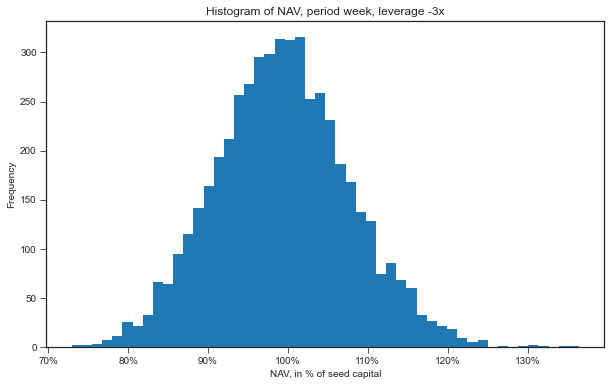

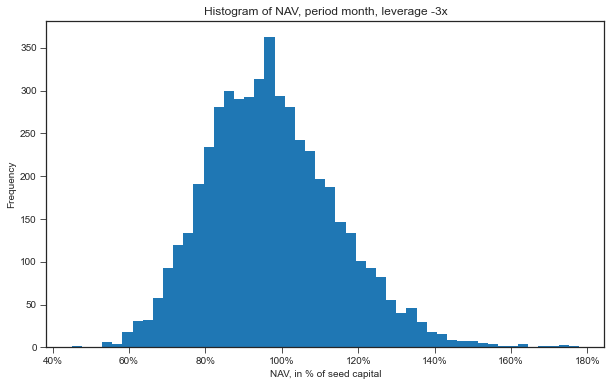

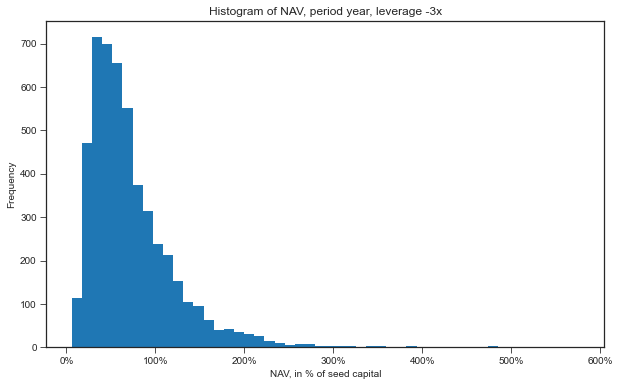

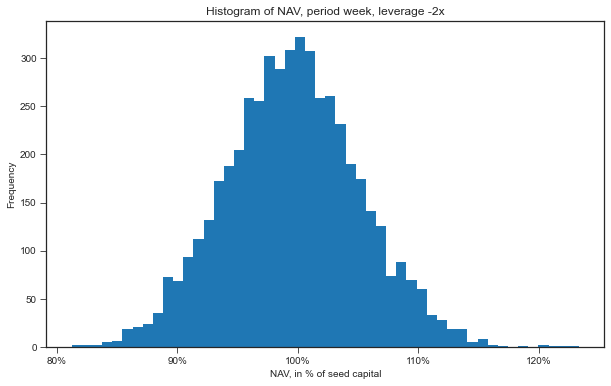

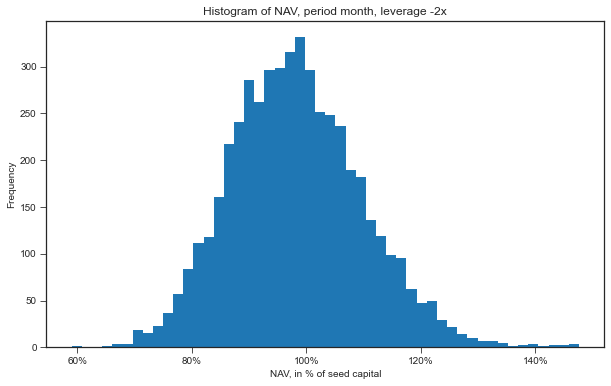

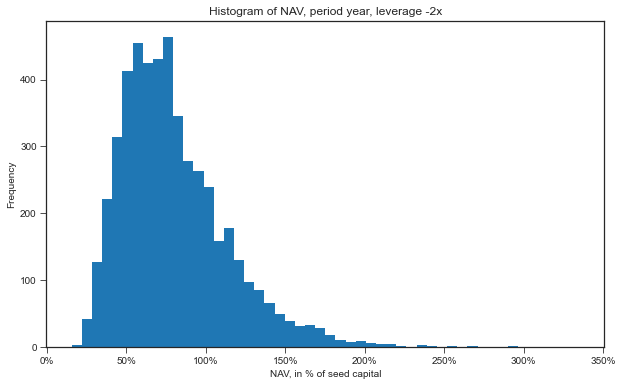

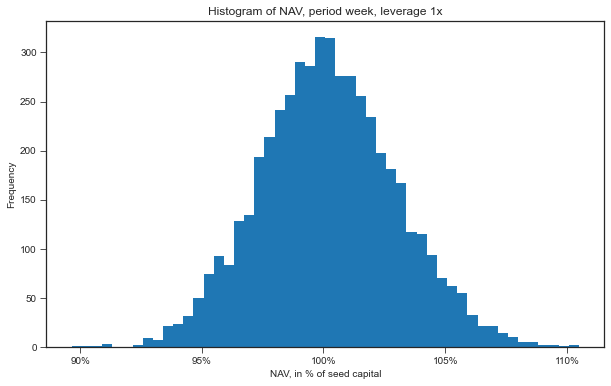

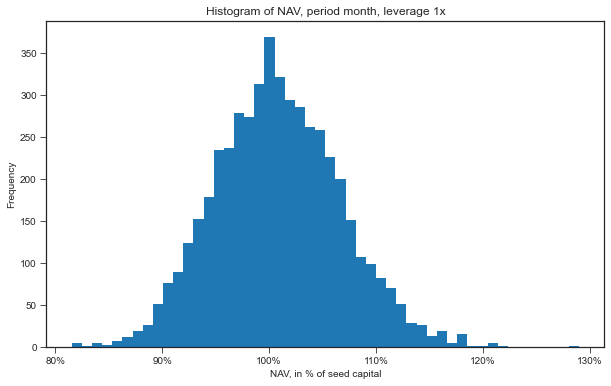

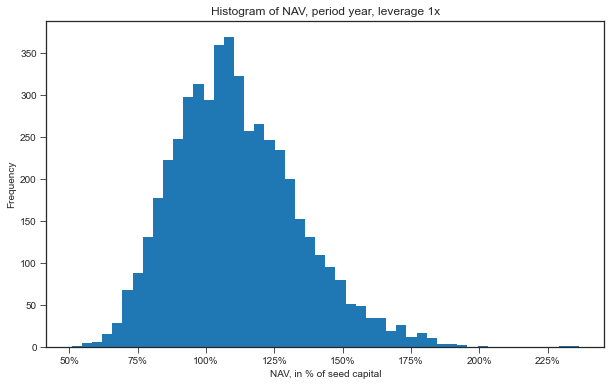

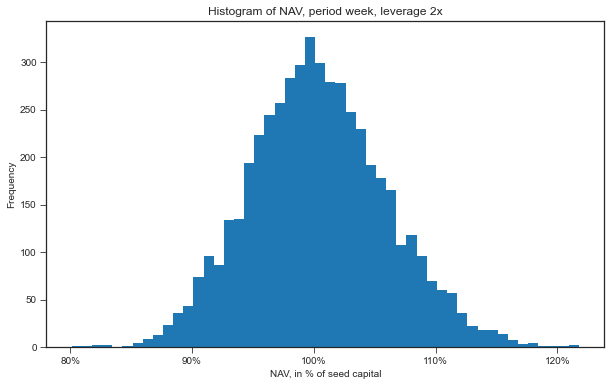

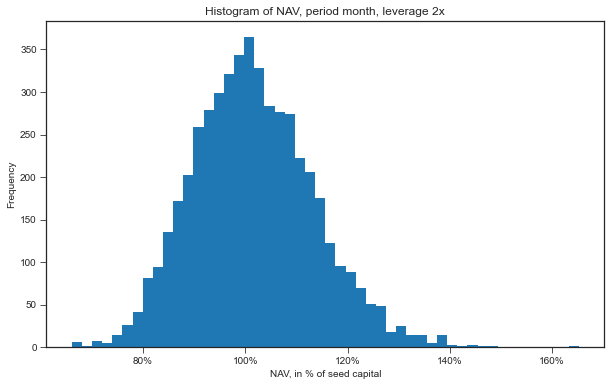

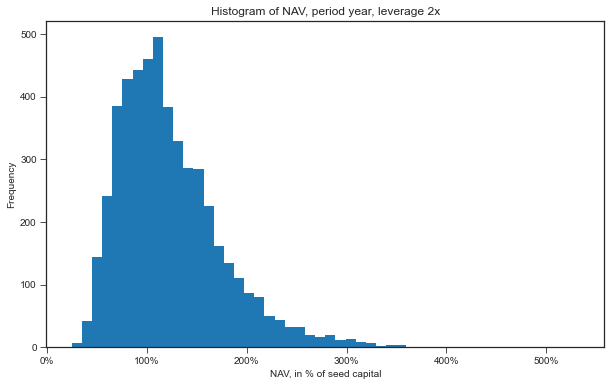

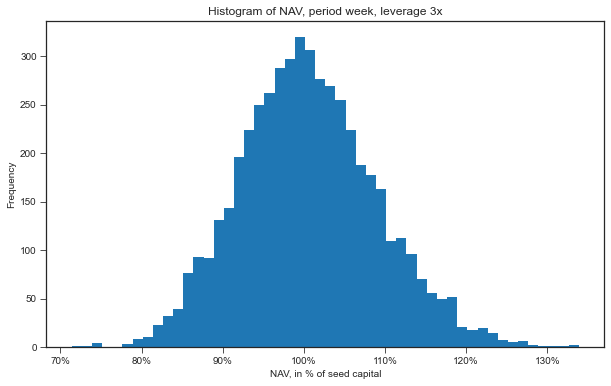

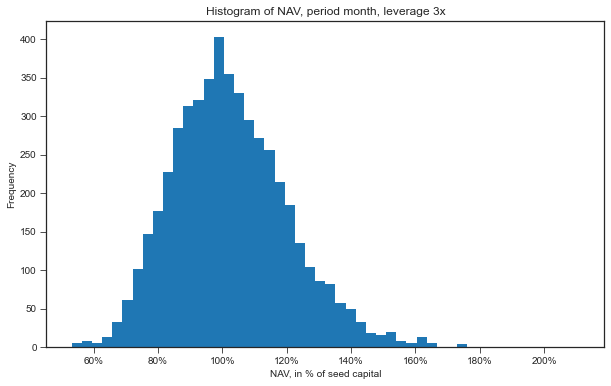

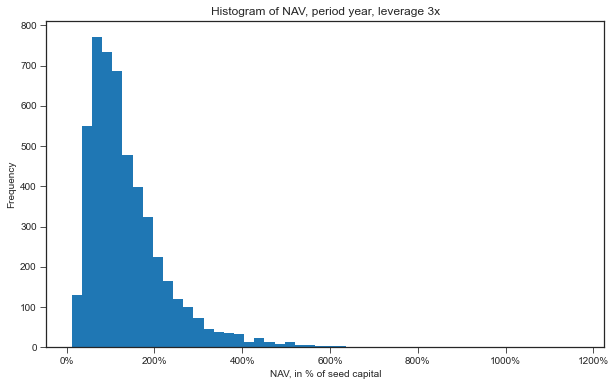

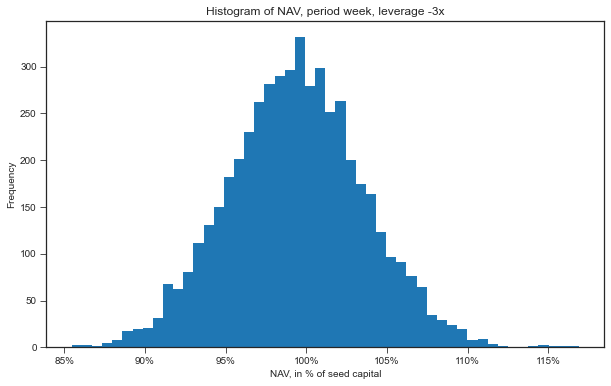

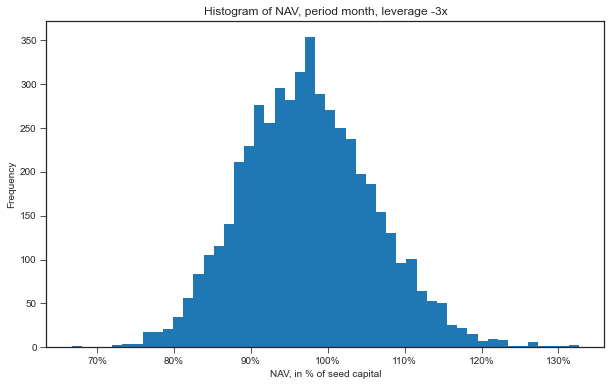

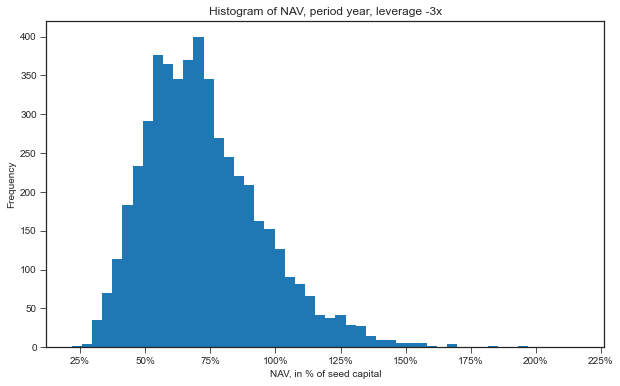

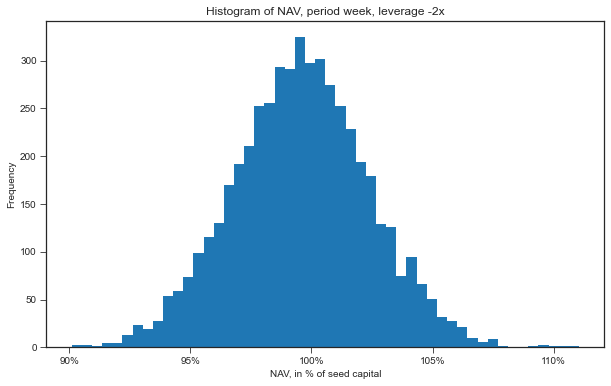

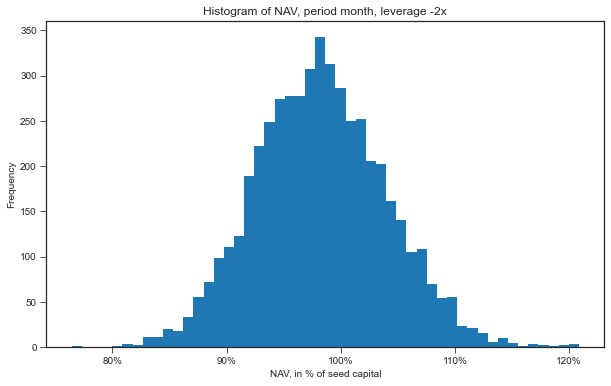

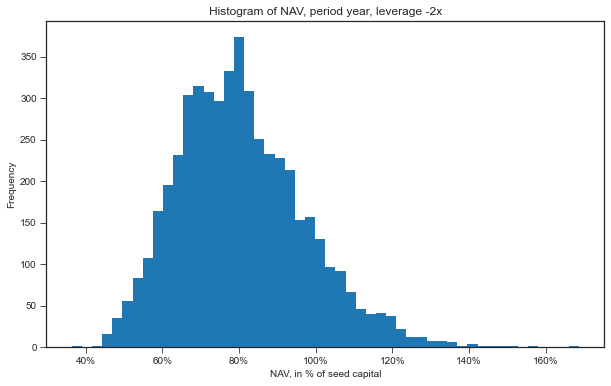

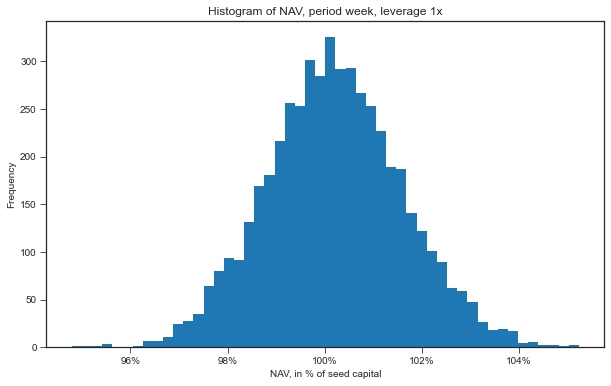

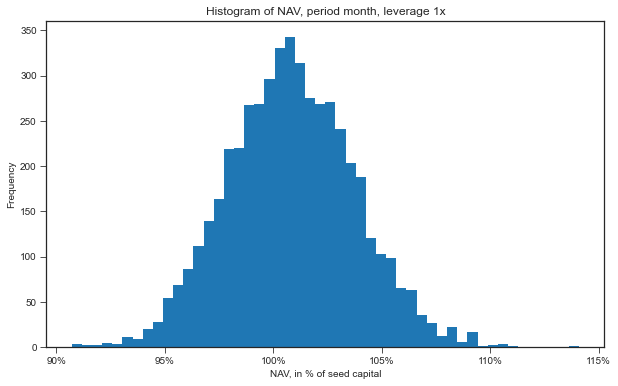

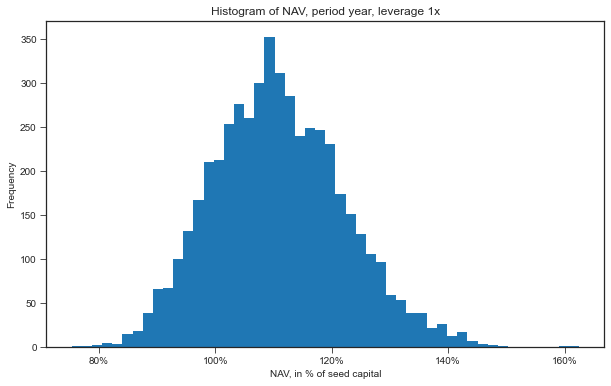

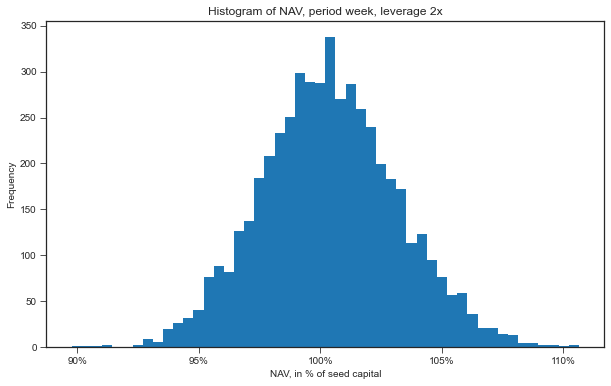

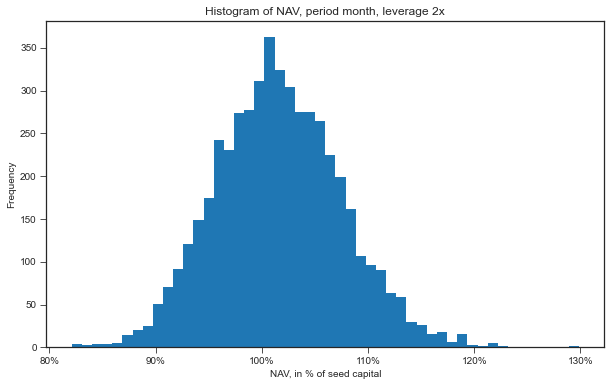

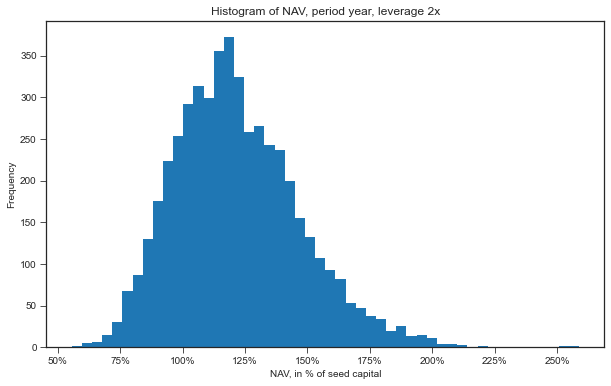

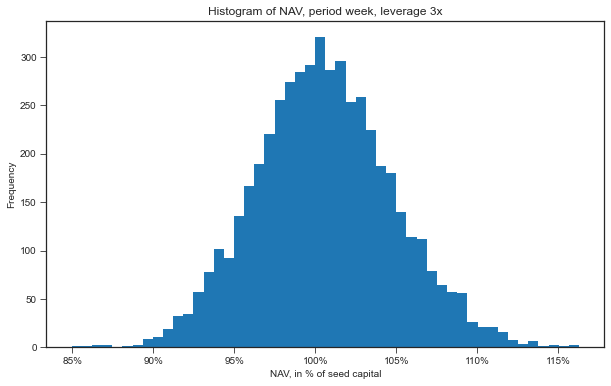

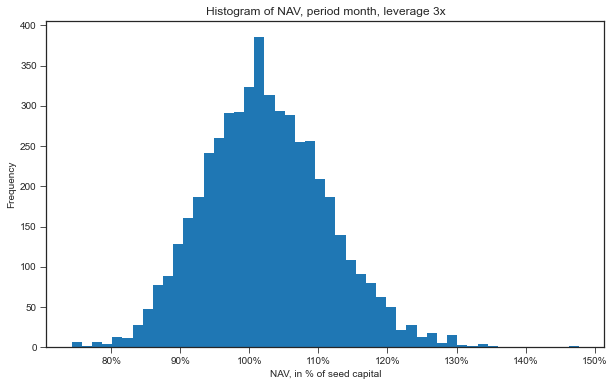

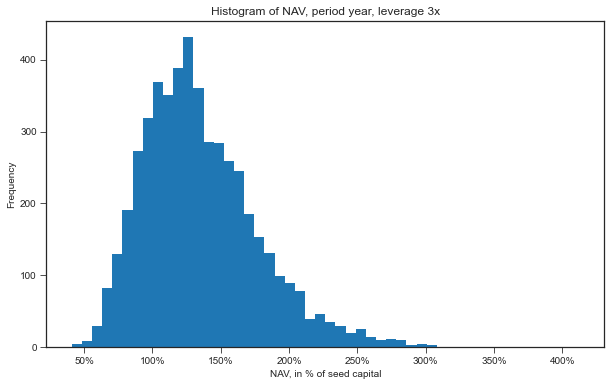

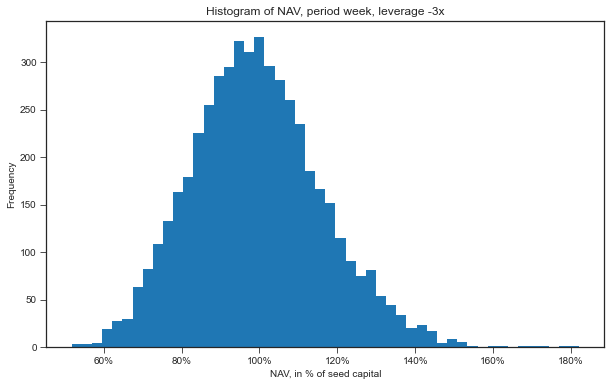

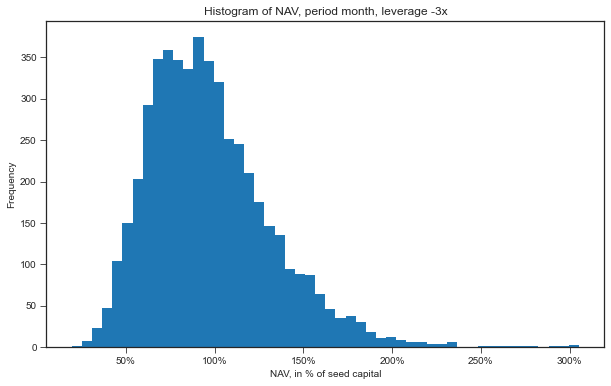

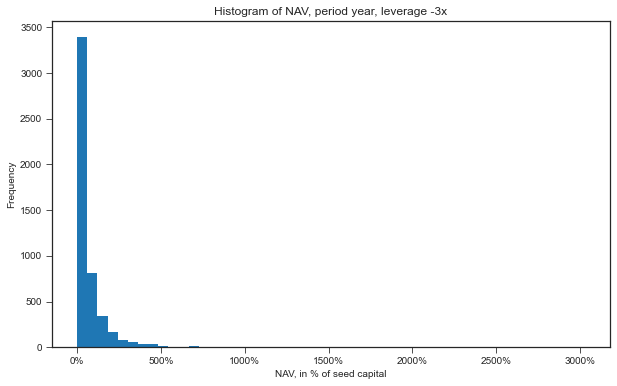

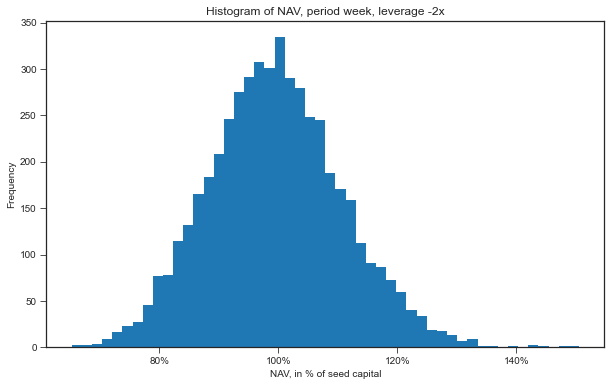

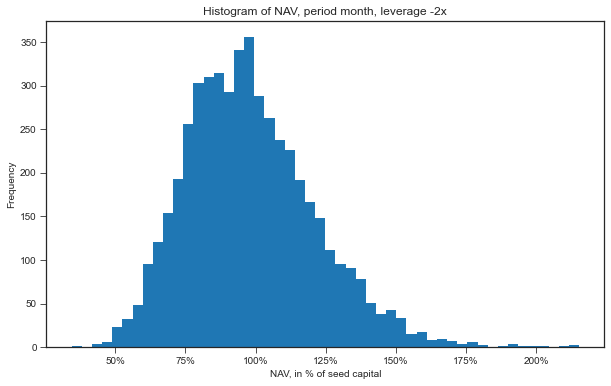

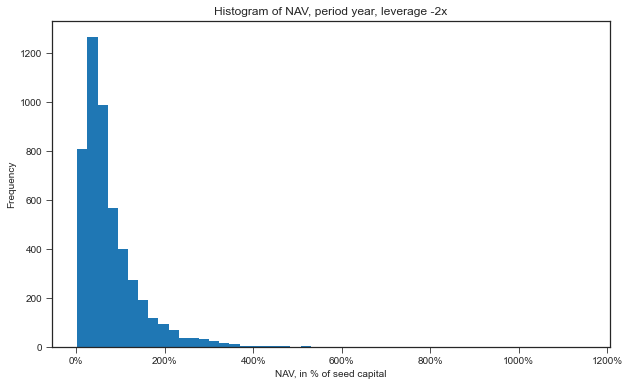

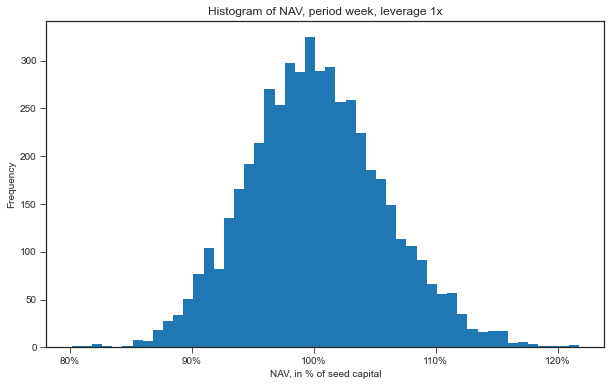

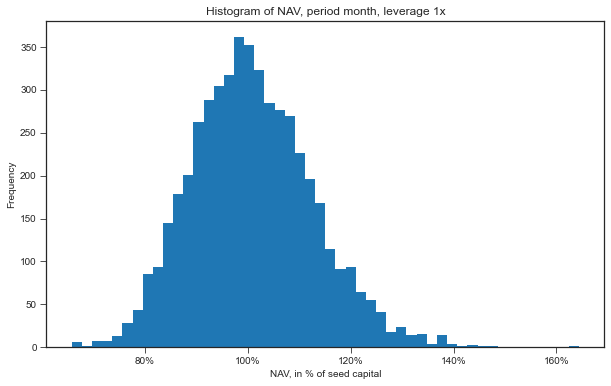

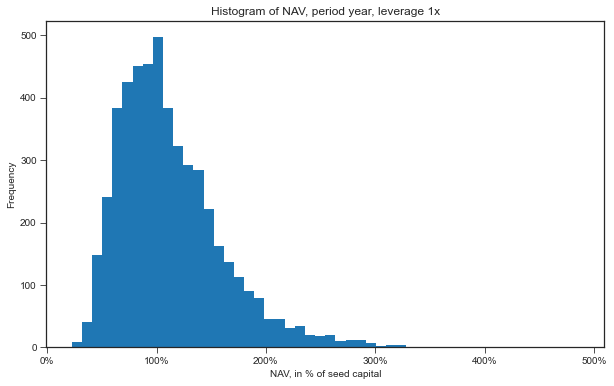

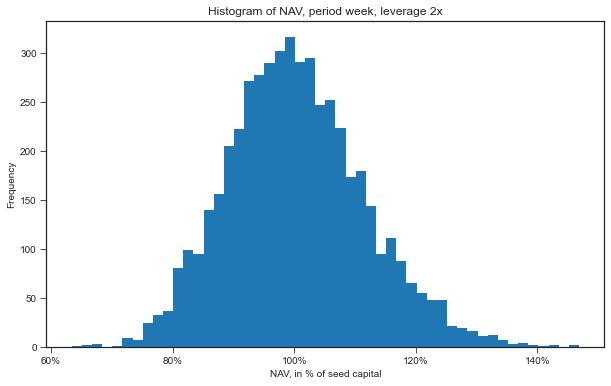

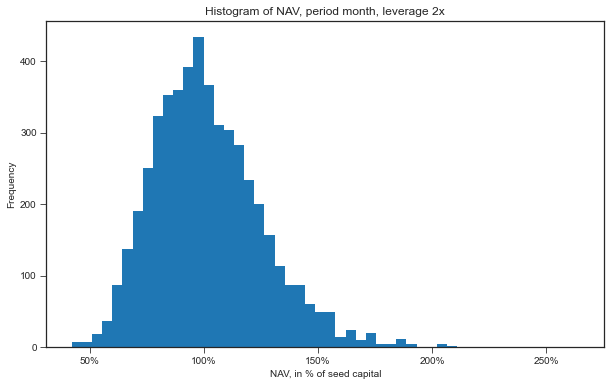

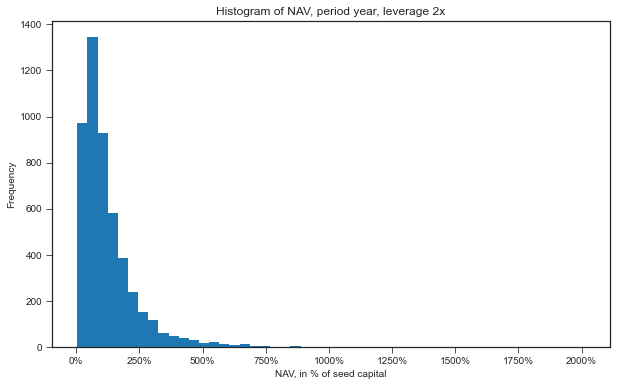

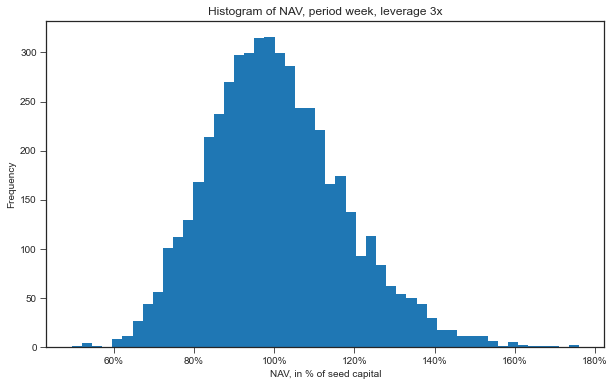

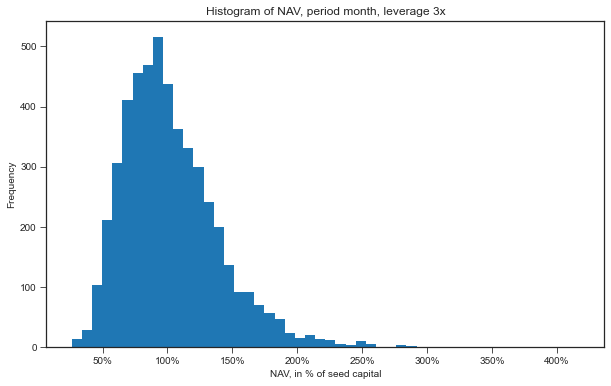

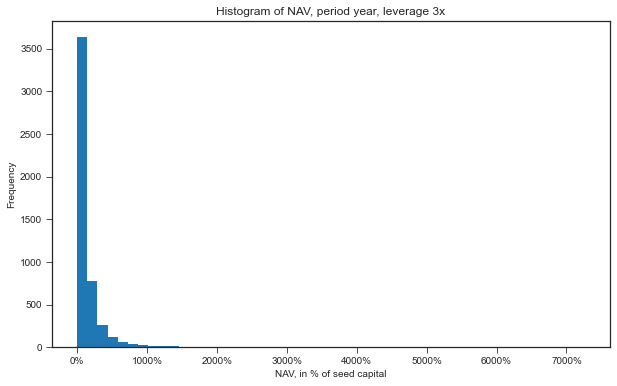

In [13]:
# Create Graphs of histogram for week, month and year and save it

for iType,iLevs in Part_1['LETF'].items():
    
    for iLeverage,iNAV in iLevs.items():
    
        for iPeriod, iIndex in [('week',5),('month',21),('year',252)]:

            iDay = iNAV.loc[iIndex] # take the last day of a holding period

            plot_Hist(iDay,'{0}_{1}_{2}'.format(iType,iLeverage,iPeriod),iPeriod,iLeverage)

## Part 3

The data was preprocessed and loaded into the data folder of the project.

In [14]:
Part_3 = {}

In [15]:
Bloom_Data_Url = 'Data/LETF_from_Bloomberg.xlsx'

Part_3['LETF'] = {}

Part_3['LETF']['Price'] = pd.read_excel(io=Bloom_Data_Url, sheet_name='Prices', index_col='Date')
Part_3['LETF']['NAV'] = pd.read_excel(io=Bloom_Data_Url, sheet_name='NAVs', index_col='Date')

Part_3['LETF']['Price'].columns = [icol.replace(' US ','').replace('Equity','') for icol in  Part_3['LETF']['Price'].columns]
Part_3['LETF']['NAV'].columns = [icol.replace(' US ','').replace('Equity','') for icol in  Part_3['LETF']['NAV'].columns]

In [16]:
# Read underlyings data
def Read_Under(UnderName='Underlying 7_10', PathToFile='Data/LETF_from_Bloomberg (2).xlsx'):
    tempDF = pd.read_excel(io=PathToFile, sheet_name=UnderName, index_col='Date Final', usecols='E,N')
    tempDF.index.name = 'Date'
    tempDF.columns = [UnderName]
    tempDF.sort_index(inplace=True)
    return tempDF

Part_3['LETF']['Underlying 7_10'] = Read_Under()
Part_3['LETF']['Underlying 20+'] = Read_Under(UnderName='Underlying 20+')

In [17]:
# Info for ETFs

Summary_Data_Url = 'Data/Summary of LETF.xlsx'

a = pd.read_excel(io=Summary_Data_Url, usecols = 'A:G', skiprows = 1, nrows = 6, index_col ='Ticker')

b = pd.read_excel(io=Summary_Data_Url, usecols = 'A:G', skiprows = 9, nrows = 6, index_col ='Ticker')

a['Underlying'] = 'ICE U.S. Treasury 20+ Year Bond Index'
b['Underlying'] = 'ICE U.S. Treasury 7-10 Year Bond Index'

a.append(b)

Part_3['Summary'] = a.append(b)

del a,b

### Price Effiency

In [18]:
def Compute_Discrepancy(Price_DF, NAV_DF):
    '''
    Function to compute price discpreancy given to equally sized pandas DataFrames.
    
    Where holds that:
    
        Price_DF.index == NAV_DF.index and Price_DF.columns == NAV_DF.columns 
    
    Arguements:
    
        Price_DF : pandas.DataFrame
        
        NAV_DF : pandas.DataFrame
    
    '''
    
    return 100*(Price_DF-NAV_DF)/NAV_DF

In [19]:
Part_3['LETF']['Discrepancy'] = Compute_Discrepancy(Part_3['LETF']['Price'].dropna(),Part_3['LETF']['NAV'].dropna())

In [20]:
def Create_Table_2(Data, Summary_DF, Absolute = False):
    
    '''
    
    Computes descriptive statistics in a tabular form, which can be then pluged into the papper.
    
    Arguements:
    
    Data : pandas.DataFrame
    
        index : date (date of the observation)
        columns : float (value of the corresponding discrepancy for the certain asset)
        
    Summary_DF : pandas.DataFrame
    
        index : str (ETF name)
        columns : has column Leverage with str value describing leverage factor
    
    '''
    
    iTable_raw = {}
    
    if Absolute == False:
    
        for iAsset in Data.columns:

                iTable_raw[(iAsset)] = {
                    'Leverage':Summary_DF.loc[iAsset,'Leverage'],
                    '# Premium':sum(Data[iAsset]>0),
                    '# Discount':sum(Data[iAsset]<0),
                    '# Zero':sum(Data[iAsset]==0),
                    'Mean':Data[iAsset].mean(),
                    'Median':Data[iAsset].median(),
                    'Minimum':Data[iAsset].min(),
                    'Maximum':Data[iAsset].max(),
                    'St Dev':Data[iAsset].std(),
                    'Skewness':Data[iAsset].skew(),
                    'Kurtosis':Data[iAsset].kurtosis()
                } 
    
    else:
        
        for iAsset in Data.columns:

                iTable_raw[(iAsset)] = {
                    'Leverage':Summary_DF.loc[iAsset,'Leverage'],
                    '# Non-zero':sum(Data[iAsset].abs()>0),
                    '# Zero':sum(Data[iAsset]==0),
                    'Mean':Data[iAsset].abs().mean(),
                    'Median':Data[iAsset].abs().median(),
                    'Minimum':Data[iAsset].abs().min(),
                    'Maximum':Data[iAsset].abs().max(),
                    'St Dev':Data[iAsset].abs().std(),
                    'Skewness':Data[iAsset].abs().skew(),
                    'Kurtosis':Data[iAsset].abs().kurtosis()
                } 
    

    return pd.DataFrame.from_dict(iTable_raw)

In [21]:
Part_3['App_15_1'] = Create_Table_2(Part_3['LETF']['Discrepancy'],Part_3['Summary'])
Part_3['App_15_2'] = Create_Table_2(Part_3['LETF']['Discrepancy'],Part_3['Summary'],True)

Part_3['App_15_1'].to_excel('Tables/Appendix_15_1.xlsx')
Part_3['App_15_2'].to_excel('Tables/Appendix_15_2.xlsx')

display(Part_3['App_15_1'])

display(Part_3['App_15_2'])

,TMF,UBT,TLT,TBF,TBT,TMV,TYD,UST,IEF,TBX,PST,TYO
Leverage,+3x,+2x,+1x,-1x,-2x,-3x,+3x,+2x,+1x,-1x,-2x,-3x
# Premium,1224,1325,1524,1022,1093,1196,1301,1324,1637,1056,835,1122
# Discount,1350,1226,1008,1332,1384,1388,1284,1148,785,1377,1515,1459
# Zero,11,34,53,231,108,1,0,113,163,152,235,4
Mean,-0.005267,0.002582,0.021883,-0.014712,-0.025643,-0.010971,-0.026546,0.008066,0.019675,-0.0095,-0.036146,-0.037266
Median,-0.005166,0.013686,0.032776,-0.031066,-0.033173,-0.007924,0.00211,0.009552,0.026648,-0.015583,-0.042535,-0.03889
Minimum,-4.278217,-6.337379,-4.977843,-2.829964,-4.815712,-2.704509,-14.45487,-1.794821,-1.080855,-1.213522,-1.404056,-2.634034
Maximum,2.687549,3.404379,1.309017,2.949565,6.423161,4.467148,5.567317,1.295148,0.713335,2.192513,2.008653,3.127433
St Dev,0.220819,0.451556,0.258269,0.236781,0.453384,0.216444,0.751969,0.171275,0.089353,0.19075,0.172001,0.336261
Skewness,-1.723739,-1.7189,-5.718505,1.273894,0.789349,2.073321,-7.423639,-0.80434,-2.713775,1.209973,1.119047,0.010613


,TMF,UBT,TLT,TBF,TBT,TMV,TYD,UST,IEF,TBX,PST,TYO
Leverage,+3x,+2x,+1x,-1x,-2x,-3x,+3x,+2x,+1x,-1x,-2x,-3x
# Non-zero,2574,2551,2532,2354,2477,2584,2585,2472,2422,2433,2350,2581
# Zero,11,34,53,231,108,1,0,113,163,152,235,4
Mean,0.101038,0.28972,0.148364,0.148334,0.283465,0.098434,0.348279,0.112806,0.058314,0.117831,0.11834,0.219746
Median,0.06594,0.197258,0.101336,0.101454,0.193175,0.063916,0.176949,0.077101,0.044154,0.070763,0.088652,0.148881
Minimum,0.0,0.0,0.0,0.0,0.0,0.0,0.000326,0.0,0.0,0.0,0.0,0.0
Maximum,4.278217,6.337379,4.977843,2.949565,6.423161,4.467148,14.45487,1.794821,1.080855,2.192513,2.008653,3.127433
St Dev,0.196408,0.346322,0.212513,0.185122,0.354727,0.193068,0.666946,0.129113,0.070493,0.150287,0.12993,0.257204
Skewness,9.561943,5.119542,9.447866,6.119487,5.71951,10.303138,11.118307,3.947286,5.894673,4.342582,4.127437,3.823597
Kurtosis,131.451861,53.704388,154.052899,67.076241,61.584875,155.558198,198.639621,27.919815,58.648707,36.130689,33.715179,23.025695


### Behavior of price deviations

In [22]:
Part_3['LETF']['Underlying 7_10'].pct_change()

,Underlying 7_10
Date,
2016-05-02,NaN
2016-05-03,0.006527
2016-05-04,0.001144
2016-05-05,0.002476
2016-05-06,-0.002660
...,...
2021-03-31,-0.001189
2021-04-01,0.004165
2021-04-05,-0.002540


In [23]:
Tmp_20 = ['TMF','UBT','TLT','TBF','TBT','TMV']
Tmp_7_10 = ['TYD','UST','IEF','TBX','PST','TYO']

Part_3['App_16_1'] = Part_3['LETF']['Underlying 7_10'].pct_change().dropna().join(Part_3['LETF']['Discrepancy'][Tmp_7_10],how='inner').corr()
Part_3['App_16_2'] = Part_3['LETF']['Underlying 20+'].pct_change().dropna().join(Part_3['LETF']['Discrepancy'][Tmp_20],how='inner').corr()

Part_3['App_16_1'].to_excel('Tables/Appendix_16_1.xlsx')
Part_3['App_16_2'].to_excel('Tables/Appendix_16_2.xlsx')

display(Part_3['App_16_1'])
display(Part_3['App_16_2'])

,Underlying 7_10,TYD,UST,IEF,TBX,PST,TYO
Underlying 7_10,1.000000,-0.179666,0.111534,0.207090,-0.080908,-0.192323,0.111304
TYD,-0.179666,1.000000,-0.058119,-0.112152,0.071480,0.070976,-0.041114
UST,0.111534,-0.058119,1.000000,0.740528,-0.463379,-0.767568,0.061807
IEF,0.207090,-0.112152,0.740528,1.000000,-0.447039,-0.771269,0.193148
TBX,-0.080908,0.071480,-0.463379,-0.447039,1.000000,0.483364,0.037622
PST,-0.192323,0.070976,-0.767568,-0.771269,0.483364,1.000000,-0.057472
TYO,0.111304,-0.041114,0.061807,0.193148,0.037622,-0.057472,1.000000


,Underlying 20+,TMF,UBT,TLT,TBF,TBT,TMV
Underlying 20+,1.000000,-0.188877,0.182755,0.209774,-0.108724,-0.110483,0.138169
TMF,-0.188877,1.000000,0.030224,-0.137021,0.039847,-0.057582,-0.588841
UBT,0.182755,0.030224,1.000000,0.765491,-0.838114,-0.788063,-0.048699
TLT,0.209774,-0.137021,0.765491,1.000000,-0.741206,-0.660661,0.166392
TBF,-0.108724,0.039847,-0.838114,-0.741206,1.000000,0.890418,-0.033478
TBT,-0.110483,-0.057582,-0.788063,-0.660661,0.890418,1.000000,0.012226
TMV,0.138169,-0.588841,-0.048699,0.166392,-0.033478,0.012226,1.000000


In [24]:
def plot_cor_matrix(corr, mask=None):
    '''
    Function to create correlation matrix.
    '''
    f, ax = plt.subplots(figsize=(11, 9))
    sns.heatmap(corr, ax=ax,
                mask=mask,
                # cosmetics
                annot=True, vmin=-1, vmax=1, center=0,
                cmap='coolwarm', linewidths=2, linecolor='black', cbar_kws={'orientation': 'horizontal'})

In [25]:
# Temp

def Create_Table_3(Under_Name='Underlying 20+',LETF_Name=['TMF','UBT','TLT','TBF','TBT','TMV'], Summary_DF=Part_3['Summary']):
    
    '''
    Hard Coded
    '''
    
    FinalTable = None
    
    def ThreeTypes(x):
        if x == 0:
            return 2
        else:
            if x > 0:
                return 1
            else:
                return 0
    
    
    #iLETF = LETF_Name # Go with first LETF
    UnderName = Under_Name # Underlying name
    
    for iLETF in LETF_Name:

        A = Part_3['LETF'][UnderName].diff().dropna().applymap(lambda x: ThreeTypes(x)) \
            .join(Part_3['LETF']['Discrepancy'][iLETF],how='inner')

        B = A[[UnderName,iLETF]]

        B = pd.pivot_table(B,index=UnderName,values=iLETF,aggfunc={iLETF:[len,np.mean]})

        if FinalTable is None:

            FinalTable = pd.DataFrame.from_dict({'Fund':[iLETF],
              'Multiple':[Summary_DF.loc[iLETF,'Leverage']],
                '2_N':[int(B.loc[2,'len'])],
              '2_Average price deviation (%)':[B.loc[2,'mean']],
              '1_N':[int(B.loc[1,'len'])],
              '1_Average price deviation (%)':[B.loc[1,'mean']],
             '0_N':[int(B.loc[0,'len'])],
              '0_Average price deviation (%)':[B.loc[0,'mean']]})

        else:

            FinalTable = FinalTable.append(pd.DataFrame.from_dict({'Fund':[iLETF],
              'Multiple':[Summary_DF.loc[iLETF,'Leverage']],
                '2_N':[int(B.loc[2,'len'])],
              '2_Average price deviation (%)':[B.loc[2,'mean']],
              '1_N':[int(B.loc[1,'len'])],
              '1_Average price deviation (%)':[B.loc[1,'mean']],
             '0_N':[int(B.loc[0,'len'])],
              '0_Average price deviation (%)':[B.loc[0,'mean']]}))
    
    FinalTable.set_index(keys=['Fund','Multiple'], inplace=True)
    
    FinalTable.columns = pd.MultiIndex.from_product(
        [['When underlying benchmark stable','When underlying benchmark increases','When underlying benchmark decreases'],
                                                     ['N','Average price deviation (%)']])
    
    return FinalTable
    
    

Part_3['App_17_1'] = Create_Table_3(Under_Name='Underlying 7_10',LETF_Name=Tmp_7_10)
Part_3['App_17_2'] = Create_Table_3(Under_Name='Underlying 20+',LETF_Name=Tmp_20)


Part_3['App_17_1'].to_excel('Tables/Appendix_17_1.xlsx')
Part_3['App_17_2'].to_excel('Tables/Appendix_17_2.xlsx')

display(Part_3['App_17_1'])
display(Part_3['App_17_2'])

When underlying benchmark stable                              \
                                             N Average price deviation (%)   
Fund Multiple                                                                
TYD  +3x                                    26                   -0.051502   
UST  +2x                                    26                    0.051971   
IEF  +1x                                    26                    0.062516   
TBX  -1x                                    26                   -0.039994   
PST  -2x                                    26                   -0.093178   
TYO  -3x                                    26                   -0.338407   

              When underlying benchmark increases                              \
                                                N Average price deviation (%)   
Fund Multiple                                                                   
TYD  +3x                                      618                   -0.044016   
UST  +2x                                      618                    0.015191   
IEF  +1x                                      618                    0.028953   
TBX  -1x                                      618                   -0.019623   
PST  -2x                                      618                   -0.049403   
TYO  -3x                                      618                   -0.062235   

              When underlying benchmark decreases                              
                                                N Average price deviation (%)  
Fund Multiple                                                                  
TYD  +3x                                      570                    0.167841  
UST  +2x                                      570                   -0.011201  
IEF  +1x                                      570                    0.006686  
TBX  -1x                                      570                   -0.008612  
PST  -2x                                      570                   -0.004898  
TYO  -3x                                      570                   -0.129306

When underlying benchmark stable                              \
                                             N Average price deviation (%)   
Fund Multiple                                                                
TMF  +3x                                    15                    0.099586   
UBT  +2x                                    15                    0.040963   
TLT  +1x                                    15                    0.160990   
TBF  -1x                                    15                   -0.071583   
TBT  -2x                                    15                   -0.126440   
TMV  -3x                                    15                   -0.129403   

              When underlying benchmark increases                              \
                                                N Average price deviation (%)   
Fund Multiple                                                                   
TMF  +3x                                      629                   -0.023570   
UBT  +2x                                      629                    0.047174   
TLT  +1x                                      629                    0.050554   
TBF  -1x                                      629                   -0.032398   
TBT  -2x                                      629                   -0.051439   
TMV  -3x                                      629                    0.001812   

              When underlying benchmark decreases                              
                                                N Average price deviation (%)  
Fund Multiple                                                                  
TMF  +3x                                      565                    0.024944  
UBT  +2x                                      565                   -0.047576  
TLT  +1x                                      565                   -0.018002  
TBF  -1x                                      565                    0.002256  
TBT  -2x                                      565                    0.014055  
TMV  -3x                                      565                   -0.035886

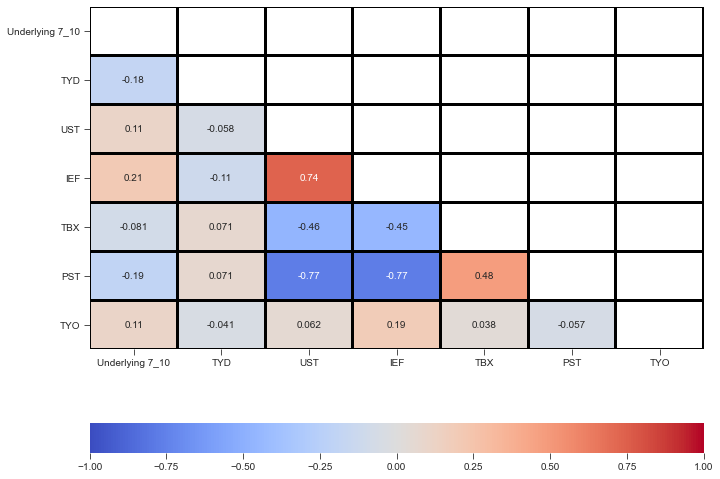

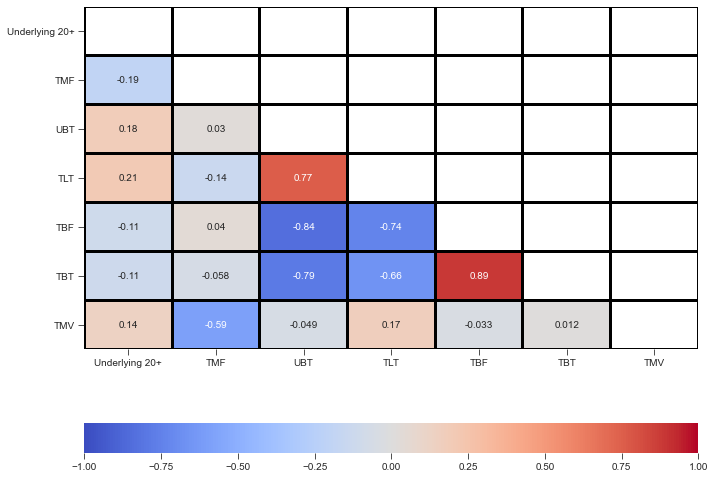

In [26]:
# Plotting without significance filtering

for app in ['App_16_1','App_16_2']:
    corr = Part_3[app]
    mask = np.triu(corr)
    plot_cor_matrix(corr,mask)
    plt.savefig("Graphs/{0}.png".format(str(app)))
    plt.show()

### Time evolution

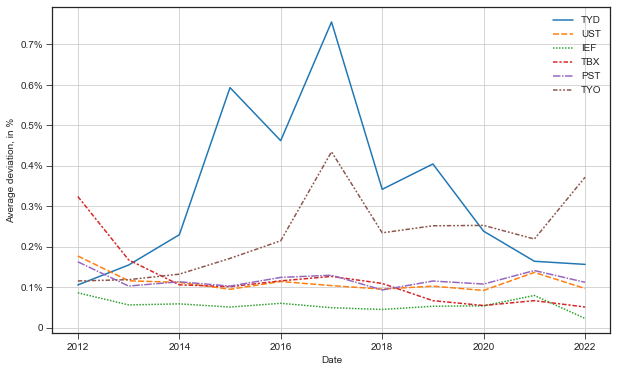

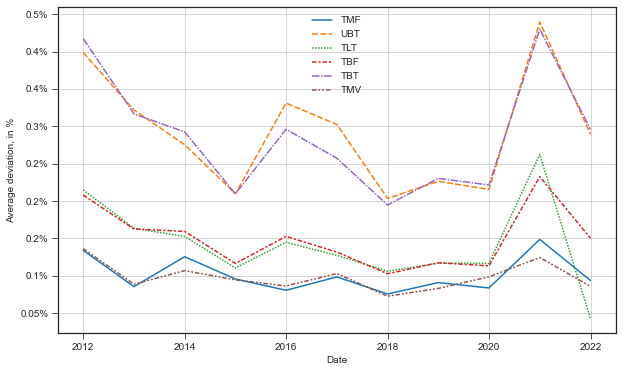

In [27]:
def Create_Table_4(Data=Part_3['LETF']['Discrepancy'][Tmp_7_10]):
    
    Data = Data.abs().resample('Y').mean()
    
    return Data

def Create_Graph_2(Data, iName):
    
    plt.style.use('seaborn-ticks')

    from matplotlib.ticker import FuncFormatter
    
    fig, ax = plt.subplots(figsize=(10, 6))

    ax = sns.lineplot(data=Data)
    
    ax.set_ylabel('Average deviation, in %')
    ax.set_xlabel('Date')
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0}'.format(x)+'%' if x>0  else str(0))) 
    
    ax.grid()

    fig.savefig("Graphs/{0}.png".format(str(iName)))
      
    plt.show()    

# Create and save
Create_Graph_2(Create_Table_4(),'Appendix_18_1')
Create_Graph_2(Create_Table_4(Part_3['LETF']['Discrepancy'][Tmp_20]),'Appendix_18_2')

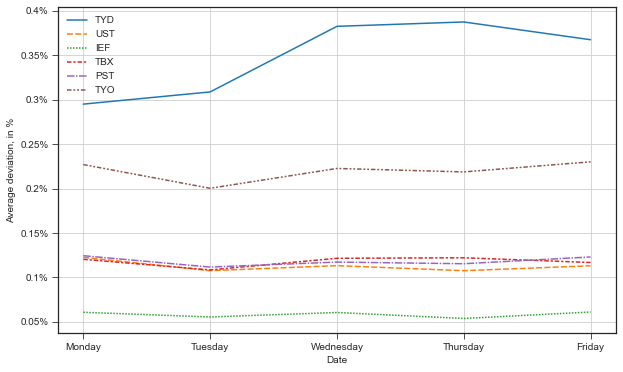

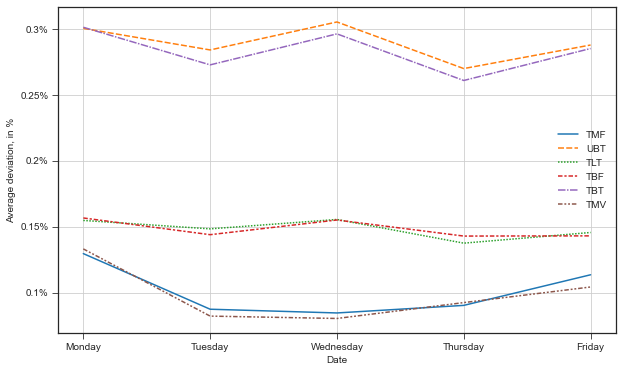

In [28]:
def Create_Table_5(Data=Part_3['LETF']['Discrepancy'][Tmp_7_10].abs()):
    
    Data = Data.groupby(Data.index.day_name()).mean()
    
    GoodOrder = ['Monday','Tuesday','Wednesday','Thursday','Friday']
    
    return Data.loc[GoodOrder,:]

def Create_Graph_3(Data,iName):
    
    plt.style.use('seaborn-ticks')

    from matplotlib.ticker import FuncFormatter
    
    fig, ax = plt.subplots(figsize=(10, 6))

    ax = sns.lineplot(data=Data)
    
    ax.set_ylabel('Average deviation, in %')
    ax.set_xlabel('Date')
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.2}'.format(x)+'%' if x>0  else str(0))) 
    
    ax.grid()

    fig.savefig("Graphs/{0}.png".format(str(iName)))
      
    plt.show()    

Create_Graph_3(Create_Table_5(),'Appendix_19_1')
Create_Graph_3(Create_Table_5(Part_3['LETF']['Discrepancy'][Tmp_20].abs()),'Appendix_19_2')

### Autoregressive pattern

In [29]:
Part_3['LETF']['Returns'] = np.log(Part_3['LETF']['Price'])-np.log(Part_3['LETF']['Price'].shift(1))

display(Part_3['LETF']['Returns'])

,TMF,UBT,TLT,TBF,TBT,TMV,TYD,UST,IEF,TBX,PST,TYO
Date,,,,,,,,,,,,
2009-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-01-02,NaN,NaN,-0.025457,NaN,0.033106,NaN,NaN,NaN,-0.014414,NaN,0.023645,NaN
2009-01-05,NaN,NaN,-0.026123,NaN,0.062710,NaN,NaN,NaN,-0.001752,NaN,0.008127,NaN
2009-01-06,NaN,NaN,-0.010108,NaN,0.010207,NaN,NaN,NaN,-0.000619,NaN,-0.004794,NaN
2009-01-07,NaN,NaN,0.003914,NaN,-0.003582,NaN,NaN,NaN,0.000206,NaN,-0.000888,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-22,-0.023939,-0.015081,-0.007637,0.008083,0.016613,0.023031,-0.001975,-0.002350,-0.001632,0.001221,0.003178,0.003672
2021-02-23,-0.008634,-0.005992,-0.002888,0.002298,0.004483,0.009339,0.001811,0.000735,0.000773,-0.000814,-0.002258,-0.003890
2021-02-24,-0.020710,-0.011281,-0.006582,0.006291,0.012349,0.018019,-0.009943,-0.002621,-0.001375,0.001220,0.003621,0.012330


In [30]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

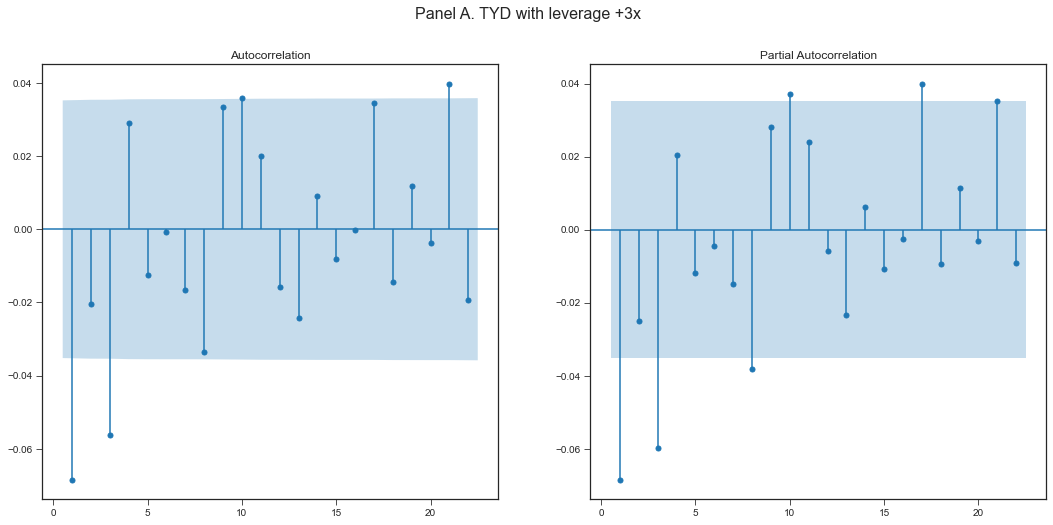

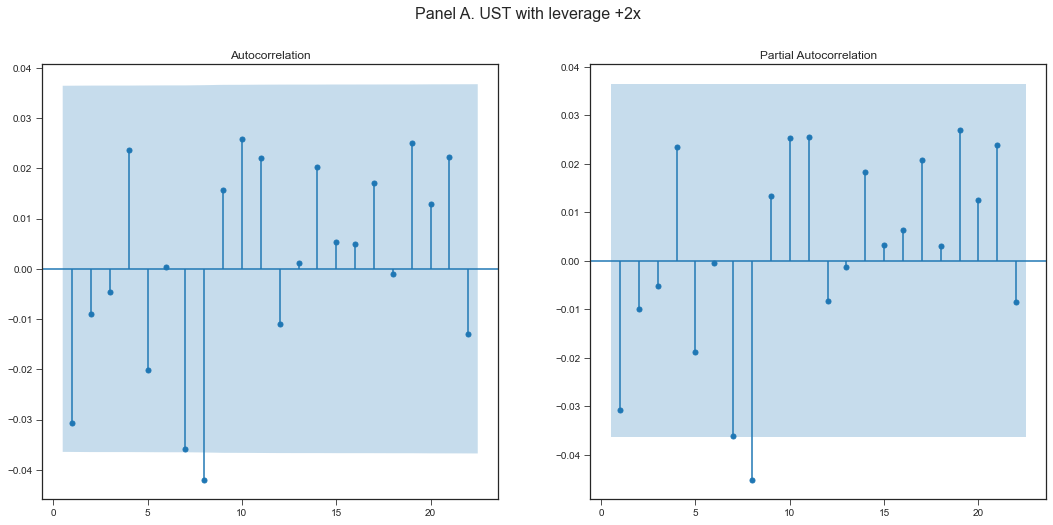

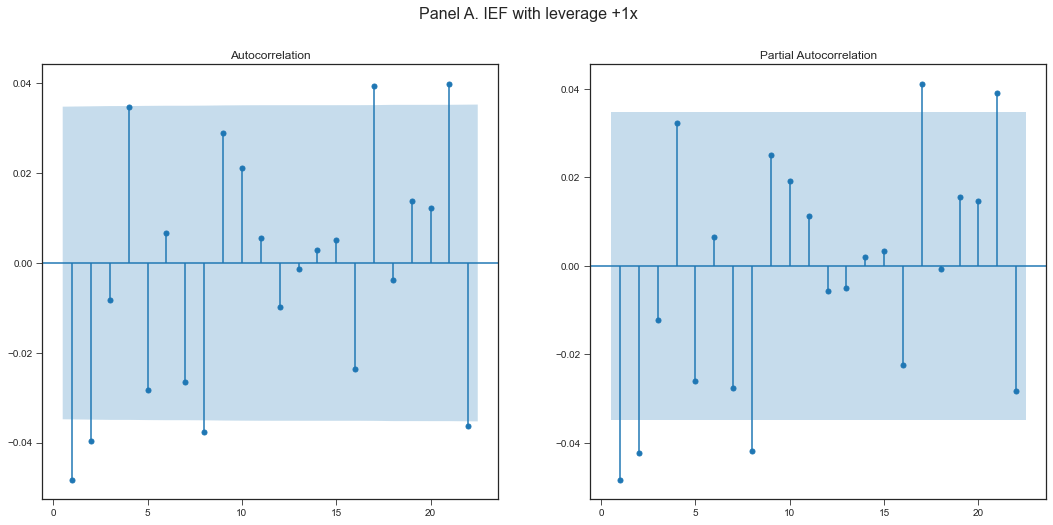

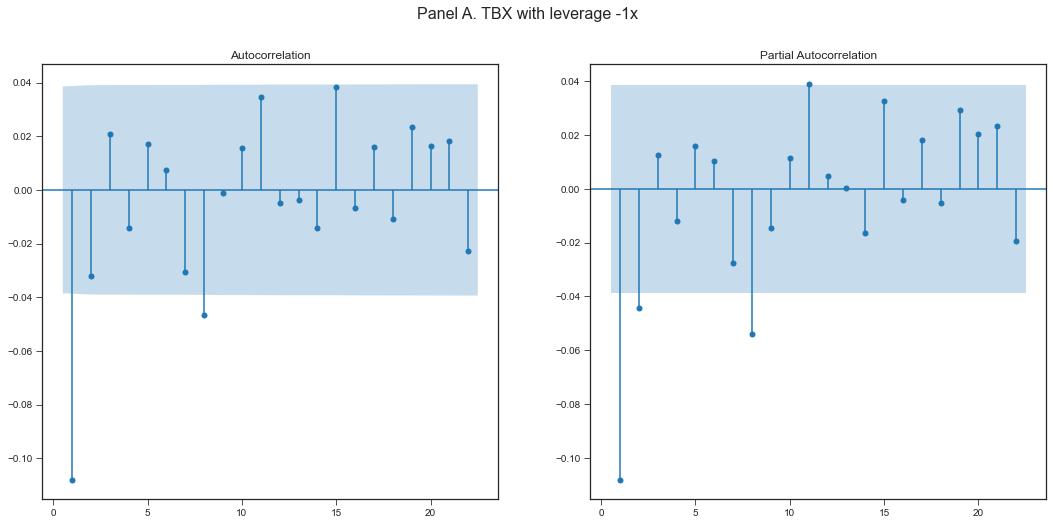

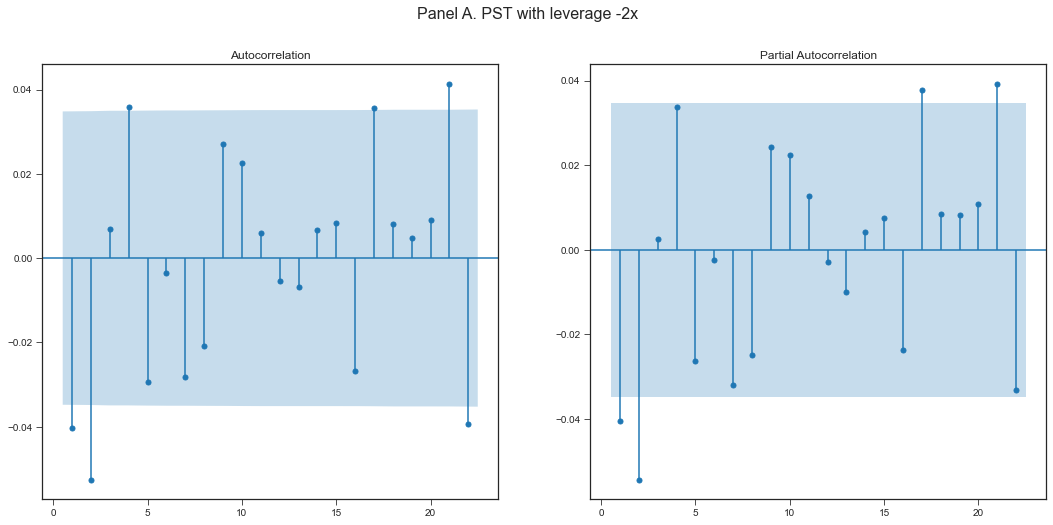

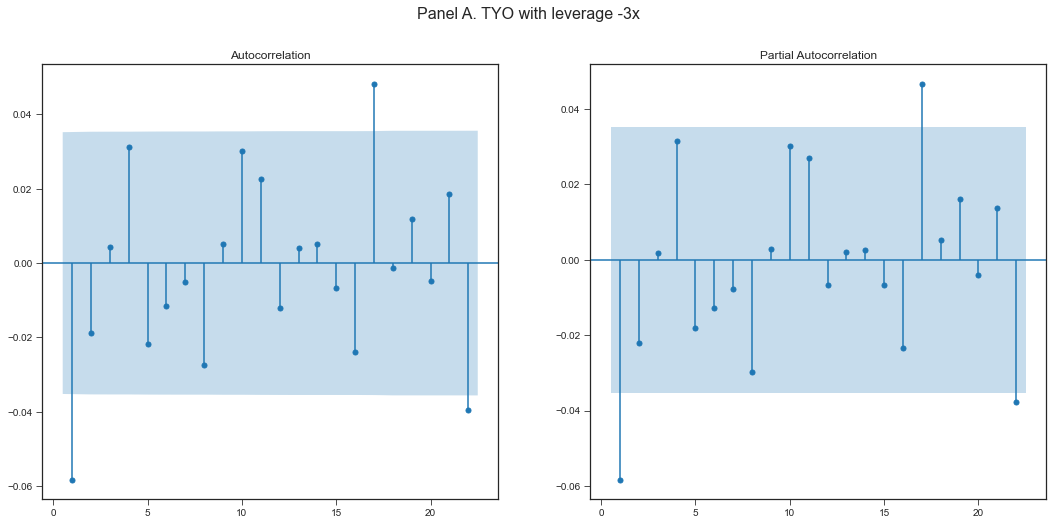

In [31]:
# For panel A

for iETF in Tmp_7_10:
    
    iData = Part_3['LETF']['Returns'][iETF].dropna().values.squeeze()
    
    fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(18,8))

    plot_acf(iData, ax=ax[0], lags=22, zero=False)
    plot_pacf(iData, ax=ax[1], lags=22, zero=False)
    
    fig.suptitle('Panel A. {0} with leverage {1}'.format(iETF,Part_3['Summary'].loc[iETF]['Leverage']), fontsize=16)
    
    fig.savefig("Graphs/Appendix_20_{0}_{1}.png".format('A',Part_3['Summary'].loc[iETF]['Leverage']))
    
    plt.show()
    
    print()

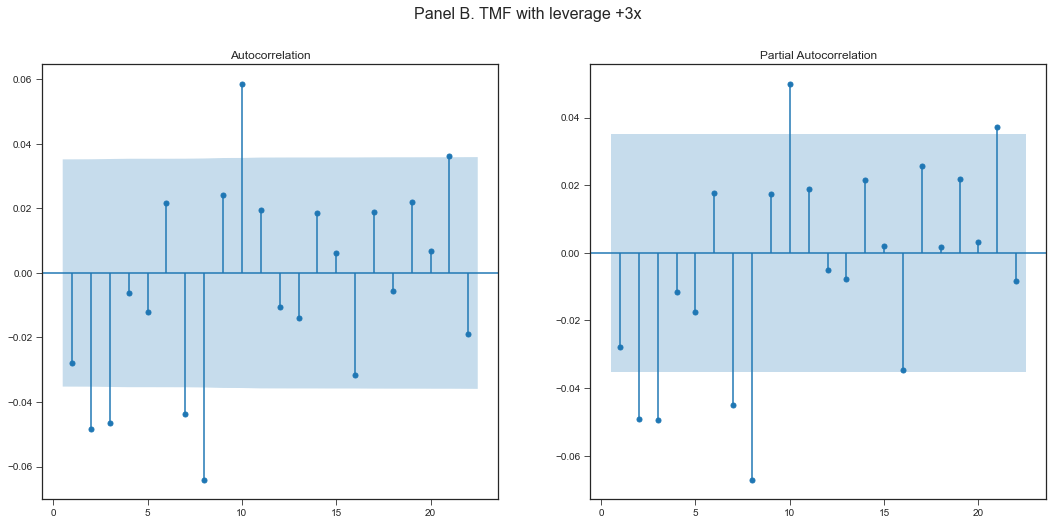

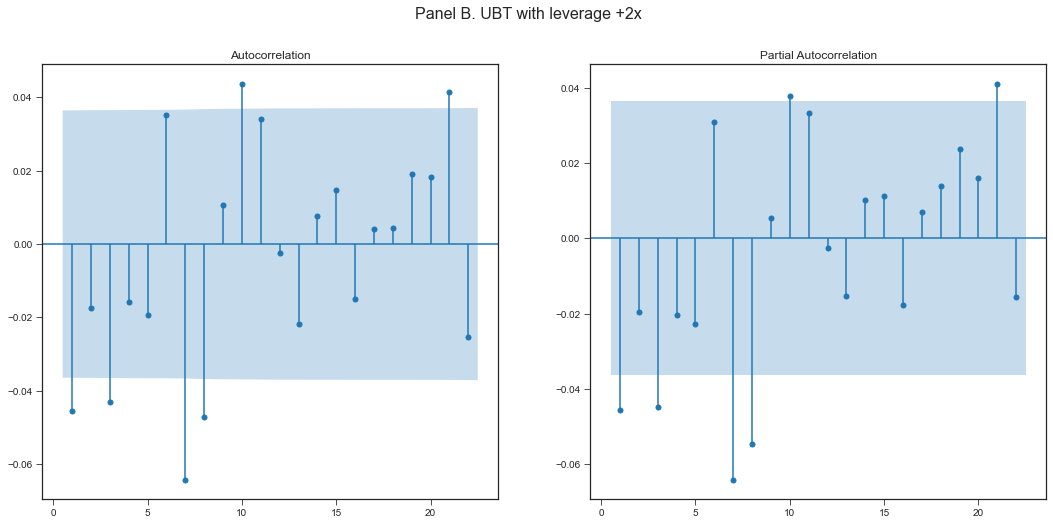

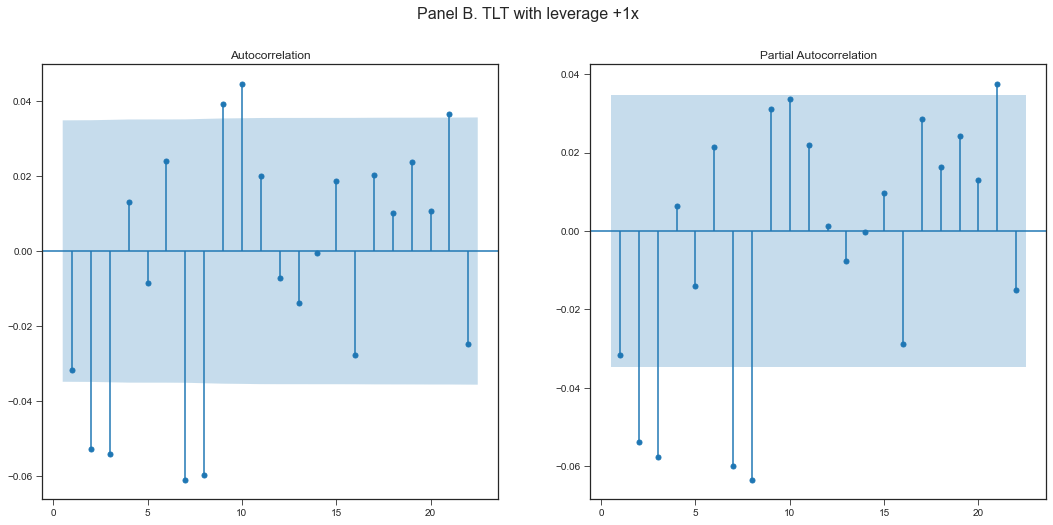

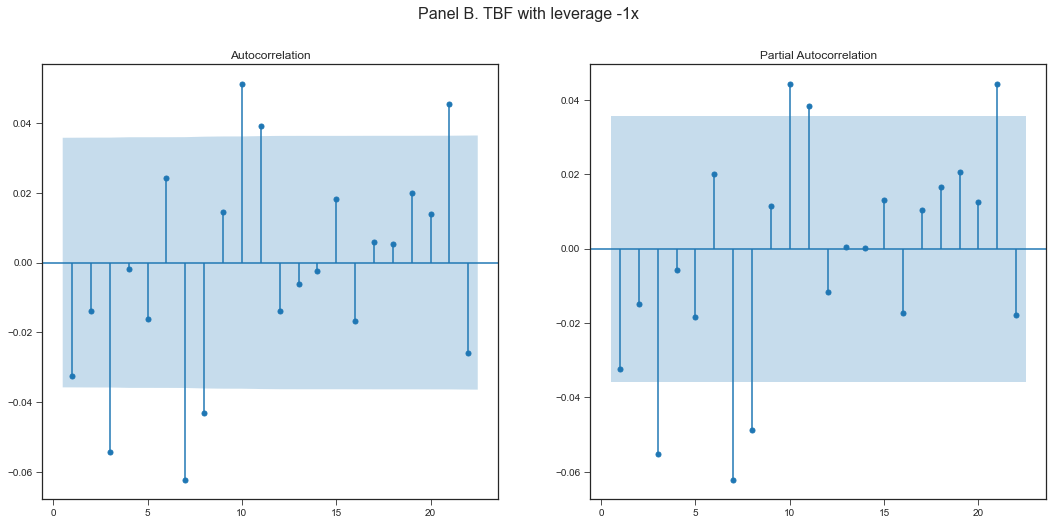

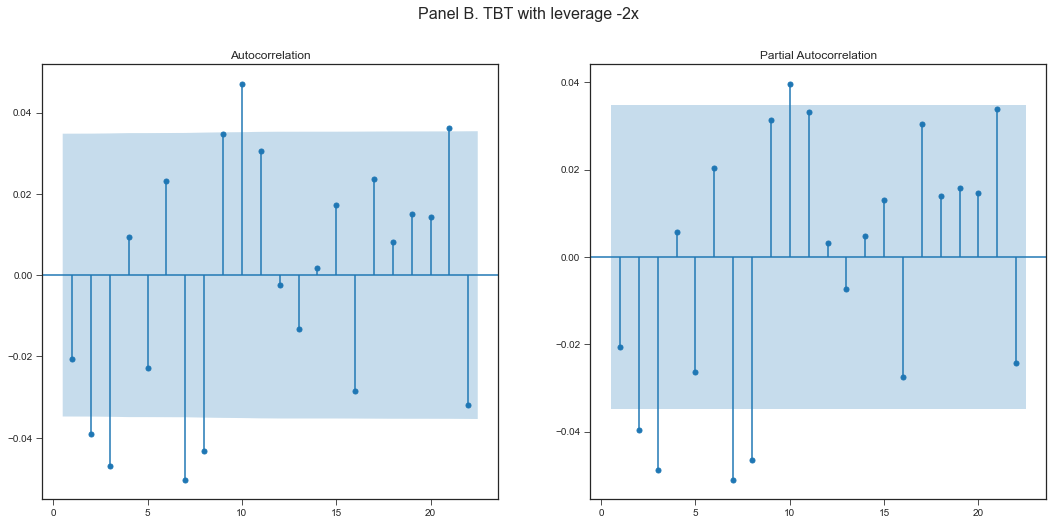

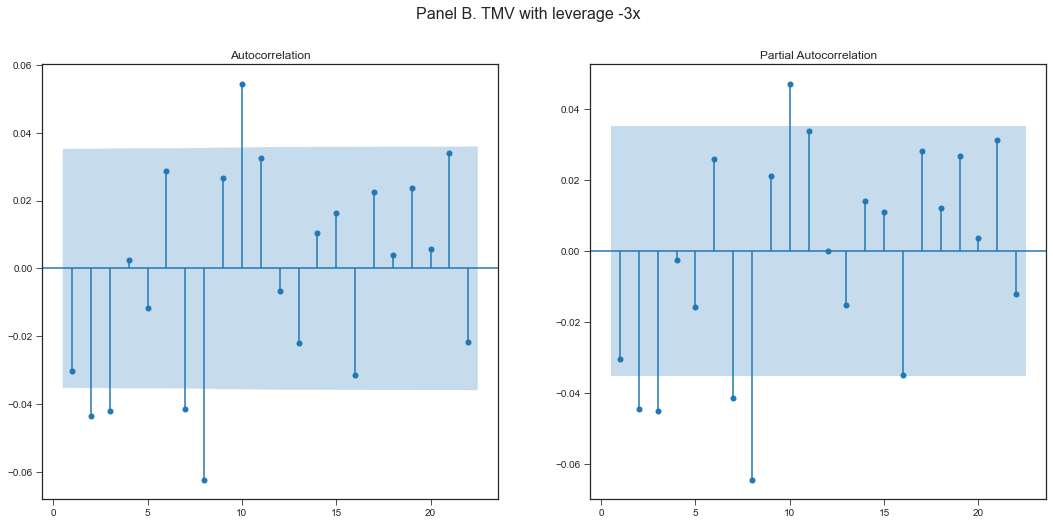

In [32]:
# For panel B

for iETF in Tmp_20:
    
    iData = Part_3['LETF']['Returns'][iETF].dropna().values.squeeze()
    
    fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(18,8))

    plot_acf(iData, ax=ax[0], lags=22, zero=False)
    plot_pacf(iData, ax=ax[1], lags=22, zero=False)
    
    fig.suptitle('Panel B. {0} with leverage {1}'.format(iETF,Part_3['Summary'].loc[iETF]['Leverage']), fontsize=16)
    
    fig.savefig("Graphs/Appendix_20_{0}_{1}.png".format('B',Part_3['Summary'].loc[iETF]['Leverage']))
    
    plt.show()
    
    print()

In [33]:
# ADF test results

from statsmodels.tsa.stattools import adfuller

Part_3['LETF']['ADF'] = pd.DataFrame(columns=['Panel','Leverage','Lags','T-stat','P-value'])

In [34]:
# For panel A

for iETF in Tmp_7_10:
    
    iData = Part_3['LETF']['Returns'][iETF].dropna().values.squeeze()
    
    iRes = adfuller(x=iData)
    
    Part_3['LETF']['ADF'].loc[iETF] = ['A',Part_3['Summary'].loc[iETF]['Leverage'],iRes[2],iRes[0],iRes[1]]

# For panel A

for iETF in Tmp_20:
    
    iData = Part_3['LETF']['Returns'][iETF].dropna().values.squeeze()
    
    iRes = adfuller(x=iData)
    
    Part_3['LETF']['ADF'].loc[iETF] = ['B',Part_3['Summary'].loc[iETF]['Leverage'],iRes[2],iRes[0],iRes[1]]
    
Part_3['LETF']['ADF'].to_excel('Tables/Appendix_21.xlsx') # Save to folder

display(Part_3['LETF']['ADF'])

,Panel,Leverage,Lags,T-stat,P-value
TYD,A,+3x,9,-17.712533,3.497076e-30
UST,A,+2x,0,-55.419199,0.000000e+00
IEF,A,+1x,7,-21.480723,0.000000e+00
TBX,A,-1x,1,-39.540399,0.000000e+00
PST,A,-2x,3,-28.122606,0.000000e+00
TYO,A,-3x,0,-58.957027,0.000000e+00
TMF,B,+3x,9,-18.427494,2.171274e-30
UBT,B,+2x,10,-16.520364,2.066929e-29
TLT,B,+1x,9,-18.570448,2.082843e-30
TBF,B,-1x,10,-16.479414,2.244449e-29


In [35]:
import statsmodels.api as sm

# Not to see anoying warnings
import warnings
from statsmodels.tools.sm_exceptions import ValueWarning,ConvergenceWarning
warnings.simplefilter('ignore', ValueWarning)
warnings.simplefilter('ignore', ConvergenceWarning)

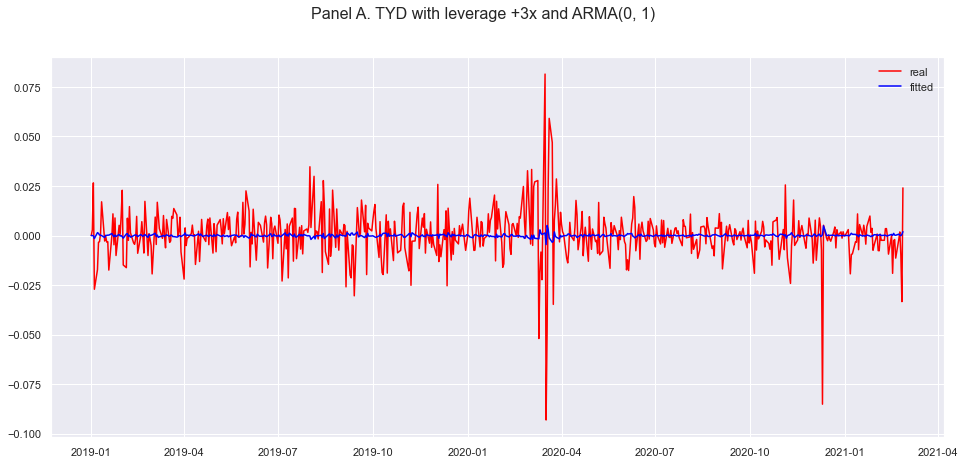

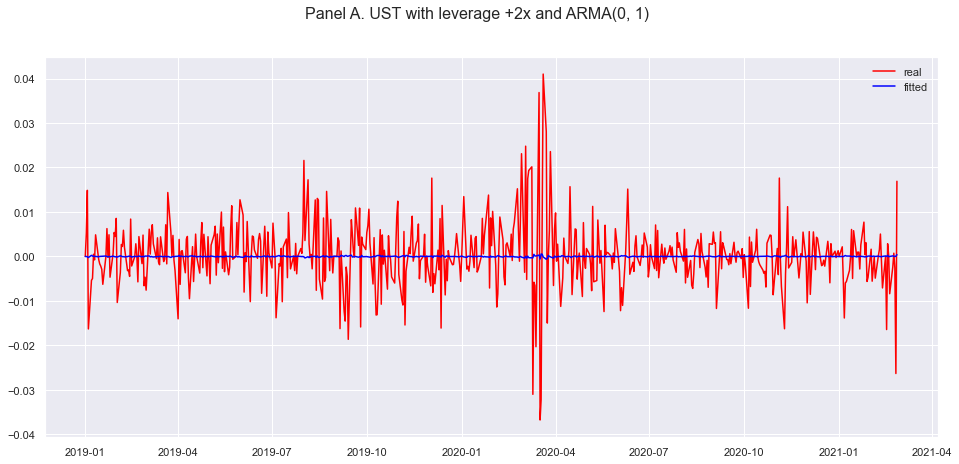

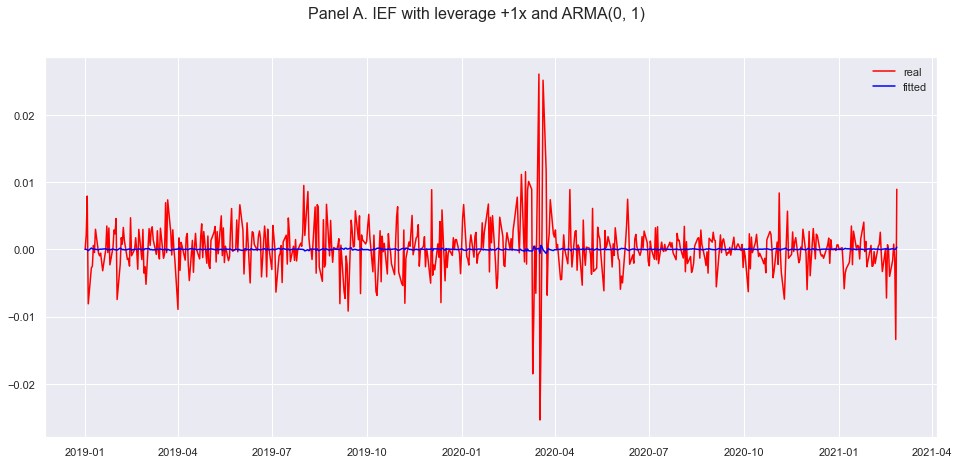

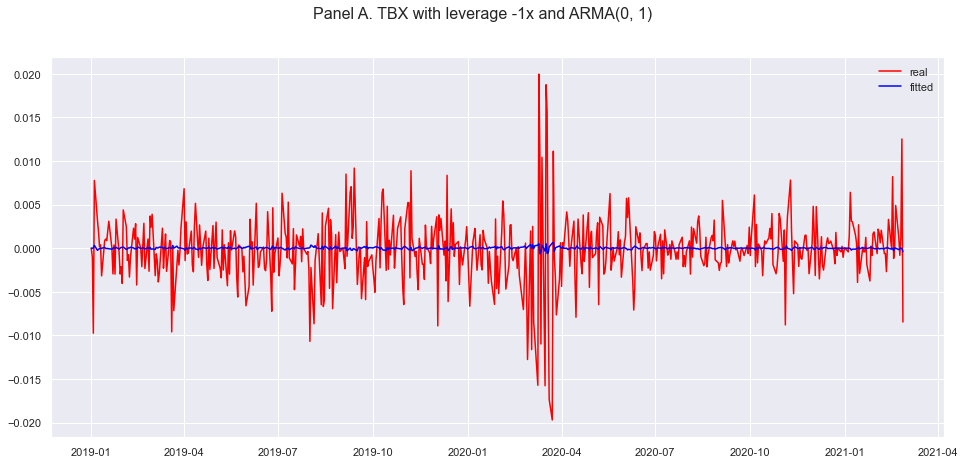

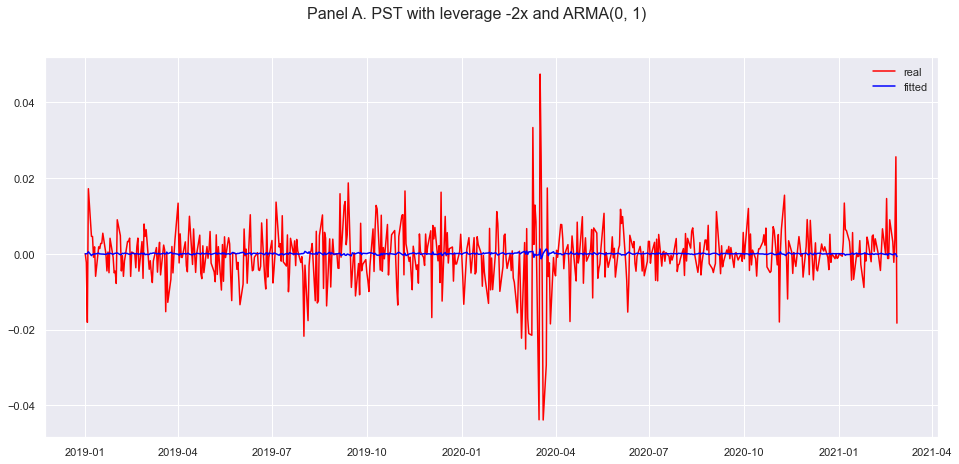

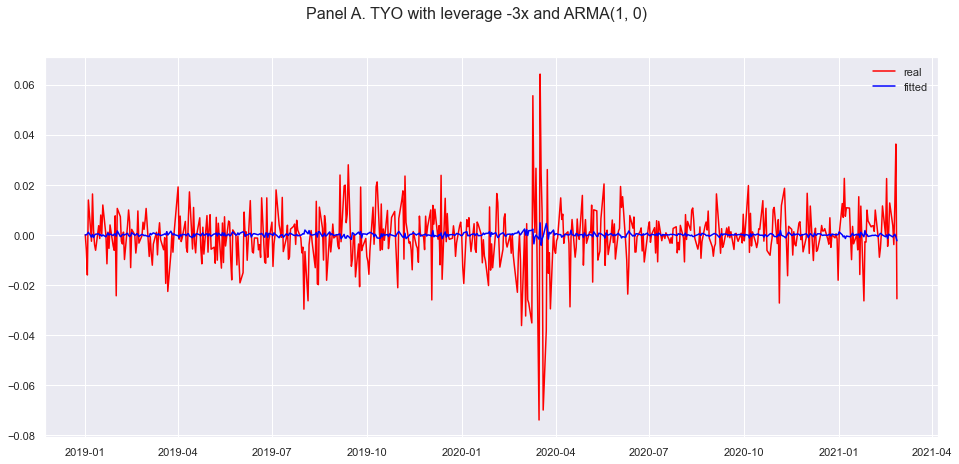

In [36]:
# For panel A

for iETF in Tmp_7_10:
    
    iData = Part_3['LETF']['Returns'][iETF].last('3Y').dropna()

    res = sm.tsa.arma_order_select_ic(y=iData, ic="bic", trend="nc", max_ar=2,max_ma=2)

    ipars = res.bic_min_order

    mod = sm.tsa.arima.ARIMA(endog=iData, order=(ipars[0], 0, ipars[1]), trend="n")
    res1 = mod.fit()

    sns.set_theme(style="darkgrid")

    fig, ax = plt.subplots(figsize=(16,7))

    ax.plot(iData, color='red', label='real')
    ax.plot(res1.predict(), color='blue',label='fitted')
    ax.legend()
    fig.suptitle('Panel A. {0} with leverage {1} and ARMA{2}'.format(iETF,Part_3['Summary'].loc[iETF]['Leverage'],ipars), fontsize=16)
    
    fig.savefig("Graphs/Appendix_22_{0}_{1}.png".format('A',Part_3['Summary'].loc[iETF]['Leverage']))
    
    plt.show()

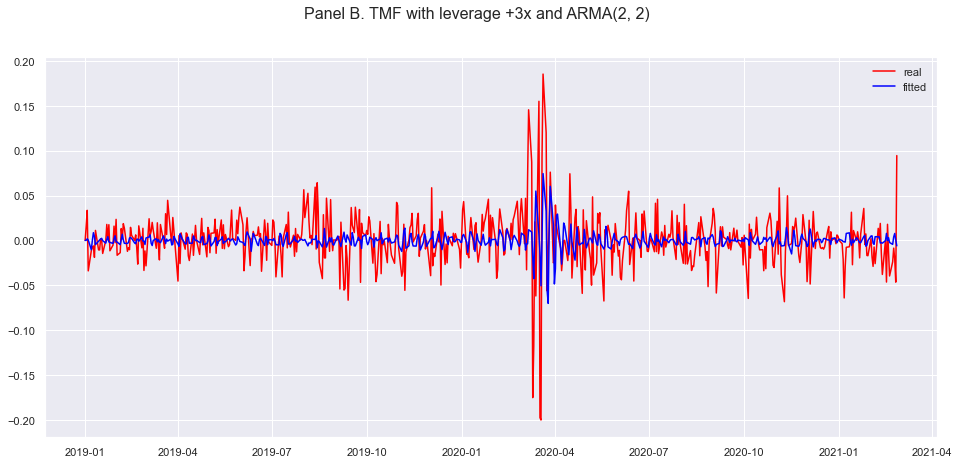

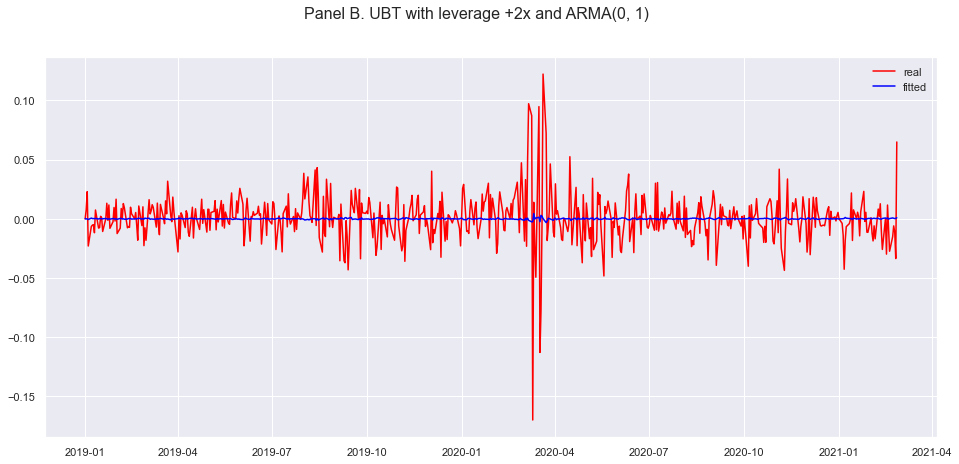

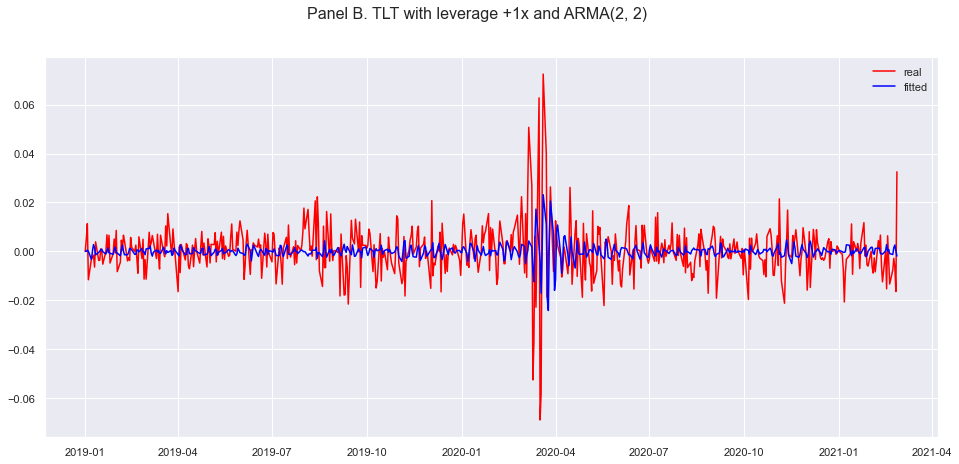

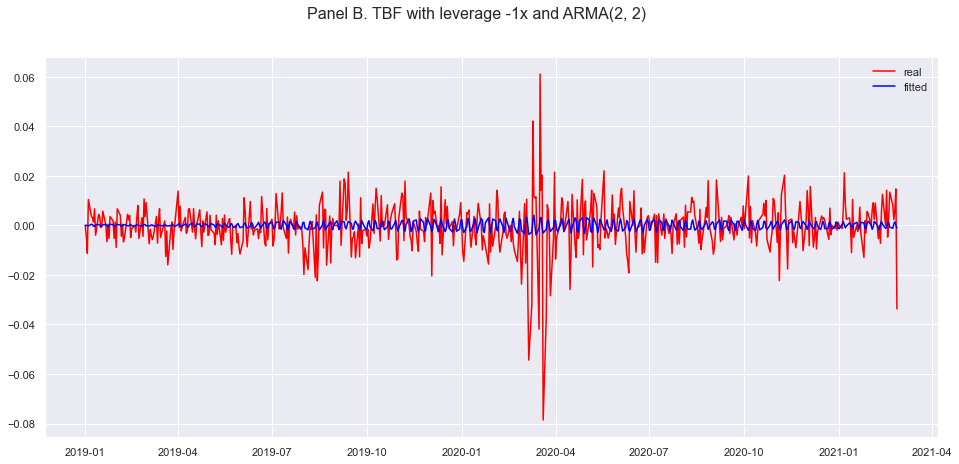

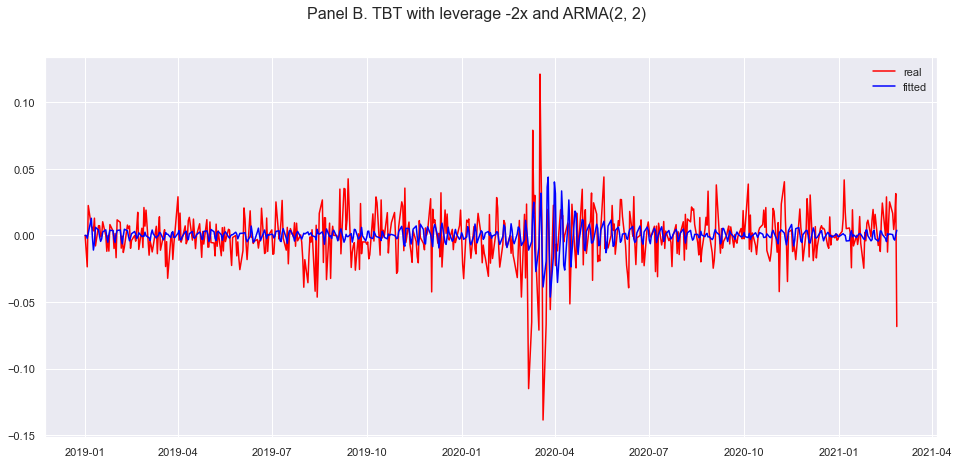

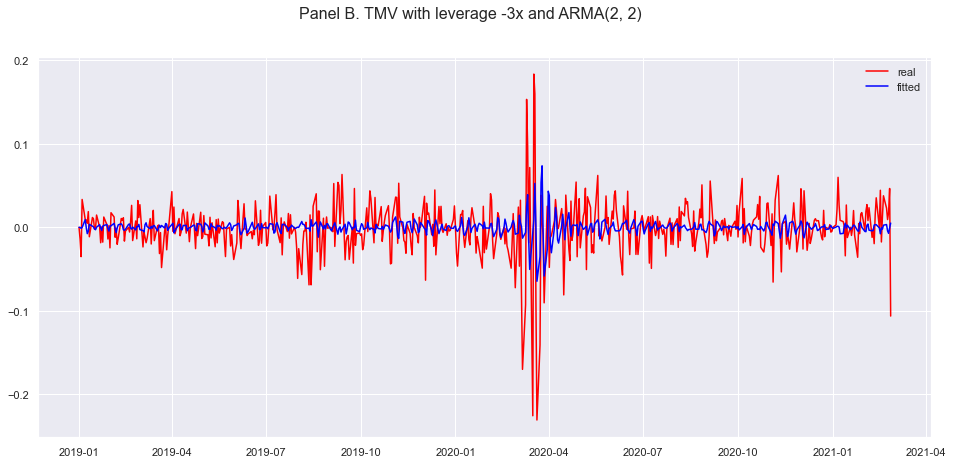

In [37]:
# For panel B

for iETF in Tmp_20:
    
    iData = Part_3['LETF']['Returns'][iETF].last('3Y').dropna()

    res = sm.tsa.arma_order_select_ic(y=iData, ic="bic", trend="nc", max_ar=2,max_ma=2)

    ipars = res.bic_min_order

    mod = sm.tsa.arima.ARIMA(endog=iData, order=(ipars[0], 0, ipars[1]),trend="n")
    res1 = mod.fit()

    sns.set_theme(style="darkgrid")

    fig, ax = plt.subplots(figsize=(16,7))

    ax.plot(iData, color='red', label='real')
    ax.plot(res1.predict(), color='blue',label='fitted')
    ax.legend()
    fig.suptitle('Panel B. {0} with leverage {1} and ARMA{2}'.format(iETF,Part_3['Summary'].loc[iETF]['Leverage'],ipars), fontsize=16)
    
    fig.savefig("Graphs/Appendix_22_{0}_{1}.png".format('B',Part_3['Summary'].loc[iETF]['Leverage']))
    
    plt.show()

## Unsorted

### Compunding effect

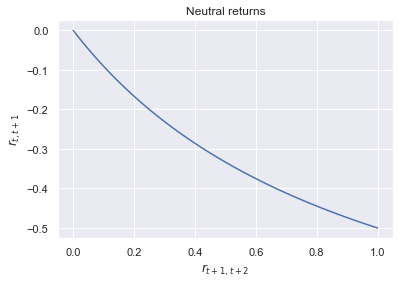

In [38]:
def netralise_return(iReturn):
    return 1/(1+iReturn)-1

df_neutral = pd.Series()

for iReturn in range(0,101):
    df_neutral.loc[iReturn/100] = netralise_return(iReturn/100)
    
fig, ax = plt.subplots()

ax = df_neutral.plot()
ax.set_xlabel(r'$r_{t+1,t+2}$')
ax.set_ylabel(r'$r_{t,t+1}$')
ax.set_title('Neutral returns')
ax.grid(True)
fig.savefig("Graphs/{0}.png".format('Neutral returns'))
plt.show()